# BDP Final Project: Assessing Credibility & Trends in Education Tweets

Qianyu(Esther) Xu

05-15-23

## 1. Setup environment and COS functions for GCS

### 1.1 Configuration

In [1]:
from pyspark.sql import SparkSession

# Create spark_session
spark = SparkSession.builder \
        .appName("LargeDataAnalysis") \
        .config("spark.num.executors", 50) \
        .config("spark.executor.cores", 8) \
        .config("spark.executor.memory", "30g") \
        .config("spark.cores.max", 50) \
        .config("spark.driver.cores", 4) \
        .config("spark.driver.memory", "16g") \
        .config("spark.driver.maxResultSize", "16g") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "512m") \
        .getOrCreate()
    
# Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

# Ensure using the right kernel
print("Spark version:", spark.version)

Spark version: 3.1.3


In [2]:
# Increasing the number of partitions can help distribute the workload more evenly across the nodes,improving performance.
# num_partitions = num_executors * num_cores_per_executor * 2 = 32 * 4 * 2 = 256

# num_executors = int(spark.conf.get("spark.num.executors"))
# num_cores_per_executor = int(spark.conf.get("spark.executor.cores"))
# total_cores =  num_executors * num_cores_per_executor

# num_partitions = total_cores * 2
# num_partitions

### 1.2 Run this Notebook on GCP with Dataproc

In [3]:
from google.cloud import storage
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

In [4]:
# List all files in given COS directory and print their names and sizes
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))
    
    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

# List all files in given COS directory and return a pandas DataFrame with their names and sizes
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))
    
    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)
    
    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name', 'Size'])
    
    return blobs_df

# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

In [5]:
# Reading data from open bucket
bucket_read = "msca-bdp-tweets"

# Writing data to own bucket
bucket_write = "msca-bdp-students-bucket"

folder_name = "final_project"

## 2. Read `tweets` Data

### 2.1 Review the fewer files in folder `final_project`

In [6]:
# Glance at files from open buckets
list_blobs_pd(bucket_read, folder_name)

,Name,Size
0,final_project/,0
1,final_project/_SUCCESS,0
2,final_project/part-00000-45990c9b-83d6-4f5e-bbcf-68819176eff0-c000.json,4263295
3,final_project/part-00001-45990c9b-83d6-4f5e-bbcf-68819176eff0-c000.json,3929421
4,final_project/part-00002-45990c9b-83d6-4f5e-bbcf-68819176eff0-c000.json,4437570
...,...,...
54132,final_project/part-54130-45990c9b-83d6-4f5e-bbcf-68819176eff0-c000.json,11194422
54133,final_project/part-54131-45990c9b-83d6-4f5e-bbcf-68819176eff0-c000.json,11429464
54134,final_project/part-54132-45990c9b-83d6-4f5e-bbcf-68819176eff0-c000.json,11581443
54135,final_project/part-54133-45990c9b-83d6-4f5e-bbcf-68819176eff0-c000.json,10384287


In [6]:
%time

path_read = f"gs://{bucket_read}/{folder_name}"
tweets_raw_df = spark.read.json(path_read)
tweets_raw_df.count()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


23/05/15 18:03:49 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
23/05/15 18:09:55 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


99992453

In [17]:
tweets_raw_df.show(5)

+-----------+--------------------+------------------+-----------------------+-----------------+--------------+--------------+---------+------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+-------------------+--------------------+-----------------------+--------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+--------------------+-------------+---------+--------------------+--------------------+------------------+---------------------+
|coordinates|          created_at|display_text_range|               entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_u

## 3.Clean `Tweets` and Save Cleaning `Tweets` into own Bucket

### 3.1 Filter and Select `Tweets`

#### 3.1.1 Filter English `Tweets` to avoid any language related data dependencies

In [7]:
tweets_df_en = tweets_raw_df.filter(tweets_raw_df.lang == 'en')

In [9]:
tweets_df_en.count()

99992453

#### 3.1.2 Filter `Tweets` Related to Education

In [8]:
keywords = ["education", "school", "learning", "teaching", "class",
            "lesson", "course", " curriculum "," study " ,"classroom","K-12",
            "university","college","student", "teacher", "students", "teachers", 
            "professor", "professors", "lecturer","diploma", "degree", "master", 
            "bachelor", "PhD", "certificate", "homework", "assignment", "exam", 
            "test", "grade", "grades","textbook", "coursework","knowledge sharing",  
            "syllabus", "higher education", "e-learning", "online learning", 
            "distance learning", "homeschooling","research", "scholarship", "tuition", 
            "educational technology","educational institution",
            "academic", "campus", "lecture", "seminar"]

pattern = '|'.join(keywords)
tweets_df_en_filtered = tweets_df_en.filter(tweets_df_en.text.rlike(pattern))

In [9]:
filtered_nrows = tweets_df_en_filtered.count()
filtered_nrows

62278919

#### 3.1.3 Flatten and Select Some Fields from `Tweets`

In [6]:
from pyspark.sql.functions import col, count, when, isnan,avg

In [11]:
# Flatten some fields
tweets_df_flat = tweets_df_en_filtered.select(
    col("id"),
    col("created_at"),
    col("text").alias("tweet_text"),
    col("source").alias("source"),
    col("user.id").alias("user_id"),
    col("user.name").alias("user_name"),
    col("user.screen_name").alias("user_screen_name"),
    col("user.location").alias("user_location"),
    col("user.followers_count").alias("user_followers_count"),
    col("user.statuses_count").alias("user_statuses_count"),
    col("coordinates.coordinates").alias("coordinates"),
    col("place").alias("place"),
    col("retweeted_status").alias("retweeted_status"),
    col("retweeted").alias("retweeted"),
    col("is_quote_status").alias("is_quote_status"),
    col("quoted_status").alias("quoted_status"),
    col("quote_count").alias("quote_count"),
    col("reply_count").alias("reply_count"),
    col("retweet_count").alias("retweet_count"),
    col("favorite_count").alias("favorite_count"),
    col("entities.hashtags.text").alias("hashtags"),
    col("retweeted_status.id").alias("retweeted_status_id"),
    col("retweeted_status.user.id").alias("retweeted_status_user_id"),
    col("retweeted_status.user.name").alias("retweeted_status_user_name"),
    col("retweeted_status.user.screen_name").alias("retweeted_status_user_screen_name"),
    col("retweeted_status.user.location").alias("retweeted_status_user_location"),
    col("user.verified").alias("user_verified"),
    col("user.description").alias("user_description"),
)



In [13]:
n_rows = tweets_df_flat.count()
n_rows

62278919

### 3.2 Drop null or NA values

#### 3.2.1 Calculate the number or percentage of null values in each column.

In [14]:


# Calculate the percentage of null values in each column
null_counts = tweets_df_flat.agg(
    *[
        (count(when(col(c).isNull(), c)) / n_rows * 100).alias(c) 
        for c in tweets_df_flat.columns
    ]
)


In [ ]:
# Convert to pandas for easier handling
null_counts_pd = null_counts.toPandas()

# Transpose DataFrame for easier visualization
null_counts_pd = null_counts_pd.transpose()

# Add column names
null_counts_pd.columns = ["percentage_null(%)"]
null_counts_pd

,percentage_null(%)
id,0.000000
created_at,0.000000
tweet_text,0.000000
source,0.000000
user_id,0.000000
user_name,0.000000
user_screen_name,0.000000
user_location,39.373016
user_followers_count,0.000000
user_statuses_count,0.000000


#### 3.2.2 Decide on a threshold above which to drop the column

In [17]:
# Set a threshold value (e.g., 50%)
threshold = 50

# Identify the columns to drop
cols_to_drop = null_counts_pd[null_counts_pd['percentage_null(%)'] > threshold].index.tolist()

# Drop the columns
tweets_df_flat_clean = tweets_df_flat.drop(*cols_to_drop)
#tweets_df_flat_clean.printSchema()

### 3.3 Save Cleaning `Tweets` into own Bucket

Self-describing Parquet files are likely the best choice due to its efficiency and compression.

In [35]:
path_write = f"gs://{bucket_write}/shared_data/estherxu/{folder_name}"

In [19]:
tweets_df_flat_clean.write.format("parquet").mode('overwrite').save(path_write)

In [20]:
list_blobs_pd(bucket_write, "shared_data/estherxu/" + folder_name)

,Name,Size
0,shared_data/estherxu/final_project/,0
1,shared_data/estherxu/final_project/_SUCCESS,0
2,shared_data/estherxu/final_project/part-00000-7f09b531-d2e1-4f5b-a3b6-3116fb64ced7-c000.snappy.parquet,8276642
3,shared_data/estherxu/final_project/part-00001-7f09b531-d2e1-4f5b-a3b6-3116fb64ced7-c000.snappy.parquet,7863305
4,shared_data/estherxu/final_project/part-00002-7f09b531-d2e1-4f5b-a3b6-3116fb64ced7-c000.snappy.parquet,9409794
...,...,...
5846,shared_data/estherxu/final_project/part-05844-7f09b531-d2e1-4f5b-a3b6-3116fb64ced7-c000.snappy.parquet,5477900
5847,shared_data/estherxu/final_project/part-05845-7f09b531-d2e1-4f5b-a3b6-3116fb64ced7-c000.snappy.parquet,5388398
5848,shared_data/estherxu/final_project/part-05846-7f09b531-d2e1-4f5b-a3b6-3116fb64ced7-c000.snappy.parquet,5230839
5849,shared_data/estherxu/final_project/part-05847-7f09b531-d2e1-4f5b-a3b6-3116fb64ced7-c000.snappy.parquet,4917249


### 3.4 Read Cleaning `Tweets` from own Bucket

In [36]:
%time
# Read data of parquet
tweets_parquet_df = spark.read.parquet(path_write) 
tweets_parquet_df.show(5)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


23/05/18 12:44:43 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------+--------------------+--------------------+-------------------+--------------------+---------+---------------+-----------+-----------+-------------+--------------+--------+-------------------+------------------------+--------------------------+---------------------------------+-------------+--------------------+
|                 id|          created_at|          tweet_text|              source|            user_id|           user_name|user_screen_name|       user_location|user_followers_count|user_statuses_count|    retweeted_status|retweeted|is_quote_status|quote_count|reply_count|retweet_count|favorite_count|hashtags|retweeted_status_id|retweeted_status_user_id|retweeted_status_user_name|retweeted_status_user_screen_name|user_verified|    user_description|
+-------------------+--------------------+--------------------+--------------------+------

In [8]:
# Data partioning
#tweets_parquet_df = tweets_parquet_df.repartition(num_partitions)

## 4. Exploratory Data Analysis

### 4.1 Review Stats of `Tweets`

In [23]:
# Total tweets
total_tweets = tweets_parquet_df.count()
print(f"Total tweets: {total_tweets}")

Total tweets: 62278919


In [24]:
# Number of data fields
num_fields = len(tweets_parquet_df.columns)
print("Number of fields: ", num_fields)

Number of fields:  24


In [36]:
# Percentage of original tweets
original_tweets = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == False").count()

original_tweets_percentage = (original_tweets / total_tweets) * 100
print("Percentage of Original Tweets: ", original_tweets_percentage)

Percentage of Original Tweets:  32.91951005122616


In [47]:
# Percentage of retweets
#retweets = tweets_parquet_df.filter(col('retweeted_status').isNotNull()).count()
retweets = tweets_parquet_df.filter("retweeted_status IS NOT NULL").count()
retweets_percentage = (retweets / total_tweets) * 100
print("Percentage of retweets: ", retweets_percentage)

Percentage of retweets:  62.57380928528961


In [38]:
# Percentage of quoted tweets
quoted_tweets = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == True").count()
quoted_tweets_percentage = (quoted_tweets / total_tweets) * 100
print("Percentage of Quoted Tweets: ", quoted_tweets_percentage)

Percentage of Quoted Tweets:  4.50668066348422


In [174]:
from pyspark.sql.functions import year, to_date, max, min

In [80]:
# Set the legacy time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

tweets_parquet_df = tweets_parquet_df.withColumn("created_at", to_date("created_at", 'EEE MMM dd HH:mm:ss ZZZ yyyy'))

# Extract year from 'created_at'
tweets_parquet_df = tweets_parquet_df.withColumn("year", year("created_at"))

# Find min and max year
min_year = tweets_parquet_df.agg(min("year")).collect()[0][0]
max_year = tweets_parquet_df.agg(max("year")).collect()[0][0]

print(f"Min year: {min_year}, Max year: {max_year}")

Min year: 2022, Max year: 2023


### 4.2 Identify the most prolific / influential Twitterers

#### 4.2.1 Identify the most active users (By message volume (original content))

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc, sum as sql_sum

In [40]:
# Count total tweets by user
user_tweet_counts = tweets_parquet_df.groupBy("user_id","user_screen_name").count()
user_tweet_counts.show(5)

+-------------------+----------------+-----+
|            user_id|user_screen_name|count|
+-------------------+----------------+-----+
|          337503433| perpaduanmelayu|  156|
|           17973378|    NickPinkston|   11|
| 948197472442052615|     googiehyung|    1|
|1236337237433839616|  alexandraeliz_|    3|
|1146215779701907456|   BobMessenger3|   57|
+-------------------+----------------+-----+
only showing top 5 rows



In [43]:
# Count original tweets by user
user_original_tweet_counts = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == False")\
                                              .groupBy("user_id") \
                                              .count() \
                                              .withColumnRenamed("user_id", "original_user_id") \
                                              .withColumnRenamed("count", "original_count")
user_original_tweet_counts.show(5)

+-------------------+--------------+
|   original_user_id|original_count|
+-------------------+--------------+
|         1578651529|             1|
|1266093909962379268|             4|
|           17434665|            61|
|         1931201083|            15|
|           15237844|            83|
+-------------------+--------------+
only showing top 5 rows



In [44]:
# Join the two DataFrames,and get the top 10 users

top10_users = user_tweet_counts.join(user_original_tweet_counts,
                                     user_tweet_counts.user_id == user_original_tweet_counts.original_user_id,"left")\
                               .fillna(0).orderBy(desc("count")).limit(10)
top10_users

user_id,user_screen_name,count,original_user_id,original_count
1426164518581899266,iskolworks,6842,1426164518581899266,6842
1549115944735481856,jaeyunowins,6802,1549115944735481856,6804
1272479318447230977,onepostguy,6533,1272479318447230977,6533
1468164097355264002,group_kq,5541,1468164097355264002,5541
1295715136141963267,education_24x7,5165,0,0
1448410354363551747,SexualAssaultB1,4428,1448410354363551747,4428
1129718312466812930,techysaavy,4425,1129718312466812930,146
1350419912615976960,theyenvy_grace,4327,1350419912615976960,4327
1448701295318216704,SexualAssaultB2,4320,1448701295318216704,4320
1525190982223945730,EstherFelix123,4255,1525190982223945730,4255


In [45]:
# Convert to Pandas for visualization
top10_users_pd = top10_users.toPandas()

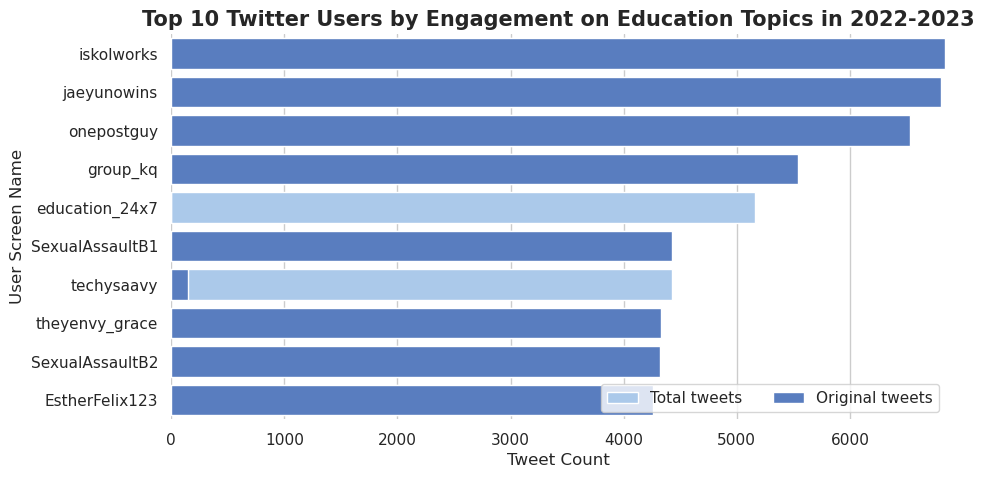

In [56]:
# Set the theme
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Plot the total tweets by each user
sns.set_color_codes("pastel")
sns.barplot(x="count", y="user_screen_name", data=top10_users_pd,
            label="Total tweets", color="b")

# Plot the original tweets by each user
sns.set_color_codes("muted")
sns.barplot(x="original_count", y="user_screen_name", data=top10_users_pd,
            label="Original tweets", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, top10_users_pd["count"].max() + 10), ylabel="User Screen Name",
       xlabel="Tweet Count", title = "Top 10 Active Twitter Users")
sns.despine(left=True, bottom=True)

# Set the title
ax.set_title('Top 10 Twitter Users by Engagement on Education Topics in 2022-2023', fontsize=15, fontweight='bold')

plt.show()

#### 4.2.2 Identify the top 10 users who their tweets are being retweeted 

In [13]:
retweets_count_by_original_df = tweets_parquet_df.filter("retweeted_status IS NOT NULL")\
    .withColumn("original_tweet_id", col("retweeted_status_id")) \
    .withColumn("original_user_screen_name", col("retweeted_status_user_screen_name")) \
    .groupBy(["original_tweet_id", "original_user_screen_name"]) \
    .count().withColumnRenamed("count","retweeted_count")


In [14]:
retweets_count_by_original_df.show(5)

+-------------------+-------------------------+---------------+
|  original_tweet_id|original_user_screen_name|retweeted_count|
+-------------------+-------------------------+---------------+
|1619361505530773506|              CapellRoyal|             27|
|1520061900129665026|             NKuliganteng|              1|
|1516490872715677698|                ranaadeem|            287|
|1611336405367623684|            Nicoletta0602|             78|
|1602677081736970240|           sophielouisecc|            378|
+-------------------+-------------------------+---------------+
only showing top 5 rows



In [15]:
top_10_users_by_retweeted = retweets_count_by_original_df\
                                    .groupBy(["original_user_screen_name"]) \
                                    .agg(avg("retweeted_count").alias("average_retweeted")) \
                                    .orderBy(col("average_retweeted").desc()).limit(10)
top_10_users_by_retweeted

original_user_screen_name,average_retweeted
PEScorpiio,28292.0
MoneyMiaaaa,22597.0
DianaMiller5,21871.0
arixhlove,20669.0
loeytaro,19052.0
BamBam1A,16317.0
CatLoverCult,12408.0
Jch_210,11882.0
gigi444444444,11143.0
ChicksRule,11116.0


In [16]:

df = tweets_parquet_df.select('user_screen_name', 'user_followers_count','user_verified',)

# Calculate average 'user_followers_count' for each 'user_screen_name'
df = tweets_parquet_df.select('user_screen_name', 'user_followers_count', 'user_verified')\
                      .groupBy('user_screen_name', 'user_verified').agg(avg('user_followers_count').alias('followers_count'))

# Now join the dataframes
top_10_users_by_retweeted = top_10_users_by_retweeted.join(df, 
    top_10_users_by_retweeted['original_user_screen_name'] == df['user_screen_name'], 
    'left_outer')

# Drop the 'screen_name' column as it's duplicate now
top_10_users_by_retweeted = top_10_users_by_retweeted.drop('user_screen_name')

# 'top_10_users_by_retweeted' dataframe should have 'verified' status and average 'user_followers_count'
top_10_users_by_retweeted.show()




+-------------------------+-----------------+-------------+------------------+
|original_user_screen_name|average_retweeted|user_verified|   followers_count|
+-------------------------+-----------------+-------------+------------------+
|             CatLoverCult|          12408.0|        false|           64932.0|
|                arixhlove|          20669.0|        false|              15.5|
|                 BamBam1A|          16317.0|         true|       1.0029087E7|
|                  Jch_210|          11882.0|         null|              null|
|            gigi444444444|          11143.0|        false|            1916.0|
|              MoneyMiaaaa|          22597.0|        false|             808.0|
|               ChicksRule|          11116.0|        false|13661.111111111111|
|               PEScorpiio|          28292.0|        false|            2419.0|
|                 loeytaro|          19052.0|         null|              null|
|             DianaMiller5|          21871.0|       

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
top_10_users_by_retweeted_pd = top_10_users_by_retweeted.toPandas()

In [23]:
top_10_users_by_retweeted_pd = top_10_users_by_retweeted_pd.sort_values(by='average_retweeted', ascending=False)
top_10_users_by_retweeted_pd

  original_user_screen_name  average_retweeted user_verified  followers_count
7                PEScorpiio            28292.0         False     2.419000e+03
4               MoneyMiaaaa            22597.0         False     8.080000e+02
9              DianaMiller5            21871.0         False     7.415500e+03
1                 arixhlove            20669.0         False     1.550000e+01
8                  loeytaro            19052.0          None              NaN
2                  BamBam1A            16317.0          True     1.002909e+07
0              CatLoverCult            12408.0         False     6.493200e+04
3                   Jch_210            11882.0          None              NaN
5             gigi444444444            11143.0         False     1.916000e+03
6                ChicksRule            11116.0         False     1.366111e+04


In [25]:
# Replace None values in 'user_verified' column with False
top_10_users_by_retweeted_pd['user_verified'] = top_10_users_by_retweeted_pd['user_verified'].fillna(False)


print(top_10_users_by_retweeted_pd)

  original_user_screen_name  average_retweeted  user_verified  followers_count
7                PEScorpiio            28292.0          False     2.419000e+03
4               MoneyMiaaaa            22597.0          False     8.080000e+02
9              DianaMiller5            21871.0          False     7.415500e+03
1                 arixhlove            20669.0          False     1.550000e+01
8                  loeytaro            19052.0          False              NaN
2                  BamBam1A            16317.0           True     1.002909e+07
0              CatLoverCult            12408.0          False     6.493200e+04
3                   Jch_210            11882.0          False              NaN
5             gigi444444444            11143.0          False     1.916000e+03
6                ChicksRule            11116.0          False     1.366111e+04


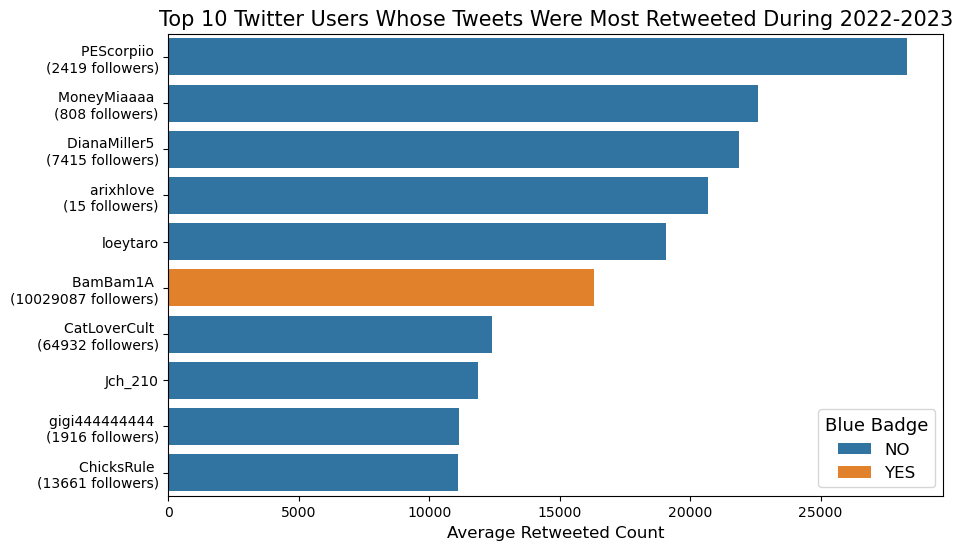

In [32]:
import numpy as np

# Create a new column in the DataFrame combining the screen name and followers count
top_10_users_by_retweeted_pd['screen_name_followers'] = top_10_users_by_retweeted_pd.apply(
    lambda row: row['original_user_screen_name'] + ' \n(' + str(int(row['followers_count'])) + ' followers)' 
    if not np.isnan(row['followers_count']) else row['original_user_screen_name'], axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

# Create barplot using the new column as the y label
sns.barplot(x='average_retweeted', y='screen_name_followers', data=top_10_users_by_retweeted_pd, 
            hue='user_verified', dodge=False, ax=ax)

# Add title and labels
ax.set_title('Top 10 Twitter Users Whose Tweets Were Most Retweeted During 2022-2023', fontsize=15)
ax.set_xlabel('Average Retweeted Count', fontsize=12)
ax.set_ylabel('')

# Customize the legend
legend = plt.legend(title='Blue Badge', title_fontsize='13', fontsize='12')

new_labels = ['NO', 'YES']  
for t, l in zip(legend.texts, new_labels): 
    t.set_text(l)

# Show the plot
plt.show()


#### 4.2.3 Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

In [37]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [38]:
# lists of known usernames for each category
gov_entities = ['usedgov',        # U.S. Department of Education
                'EdNCES',         # National Center for Education Statistics
                'IESResearch',    # Institute of Education Sciences
                'OHEducation',    # Ohio Department of Education
                'CADeptEd',       # California Department of Education
                'educationgovuk', # Department for Education (UK)
                'edutopia',       # George Lucas Educational Foundation
                'TeachtoLead',    # Teach to Lead
                'MdPublicSchools',# Maryland State Department of Education
                'NYCSchools',     # New York City Department of Education
                'UN',             # The official account for the United Nations.
                'EU_Commission',  # The official account for the European Commission.
                'education_ire',  # The official account for the Department of Education in Ireland.
               ]
universities = ['Harvard', 'Stanford', 'MIT','Yale','Princeton','Columbia',
                'UChicago','Penn','Caltech','JohnsHopkins','Cambridge_Uni','UniofOxford','UofT']

nonprofit_organizations = ['TeachForAll', 'EdTrust', 'LearningForward', 
                           '826National', 'CollegeBoard','gatesfoundation',
                           'FordFoundation','ClintonFdn']


news_outlets = ['educationweek', 'EdSurge', 'chronicle', 'insidehighered', 
                'HuffPostEdu','BBCWorld','AJEnglish','cnnbrk']

social_media_influencers = ['SirKenRobinson', 'alicekeeler', 'coolcatteacher', 'gcouros', 
                            'mindshiftkqed', 'AngelaMaiers', 'teachwithsoul', 'davidwees', 
                            'web20classroom', 'shannonmmiller','neiltyson','BillNye','ProfBrianCox']

health_organizations = ['WHO', 'CDCgov', 'NIH', 'FDArecalls','UNICEF', 
                        'MayoClinic', 'JohnsHopkinsSPH','MSF','RedCross'] 


schools = ['StuyNY', 'BronxScience', 'PhillipsExeter', 'Andover_Academy', 
           'SidwellFriends','Eton_College','GeelongGrammar','NUSingapore']

celebrities = ['elonmusk', 'Oprah', 'TheEllenShow', 'BillGates', 'MMFlint', 'BenAffleck', 
               'EmWatson', 'priyankachopra', 'KingJames', 'Malala', 'aplusk','BarackObama',
               'IvankaTrump','EmmaWatson','Malala','LeoDiCaprio']

def categorize_user(username):
    if username in gov_entities:
        return 'government entities'
    elif username in universities:
        return 'universities'
    elif username in nonprofit_organizations:
        return 'nonprofit_organizations'
    elif username in social_media_influencers:
        return 'social_media_influencers'
    elif username in schools:
        return 'schools'
    elif username in celebrities:
        return 'celebrities'
    elif username in health_organizations:
        return 'health_organizations'
    else:
        return 'other'

# Regroup Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)
categorize_user_udf = udf(categorize_user, StringType())

tweets_parquet_df = tweets_parquet_df.withColumn('user_category', categorize_user_udf('user_screen_name'))

tweets_parquet_df.show(5)


+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------+--------------------+--------------------+-------------------+--------------------+---------+---------------+-----------+-----------+-------------+--------------+--------+-------------------+------------------------+--------------------------+---------------------------------+-------------+--------------------+-------------+
|                 id|          created_at|          tweet_text|              source|            user_id|           user_name|user_screen_name|       user_location|user_followers_count|user_statuses_count|    retweeted_status|retweeted|is_quote_status|quote_count|reply_count|retweet_count|favorite_count|hashtags|retweeted_status_id|retweeted_status_user_id|retweeted_status_user_name|retweeted_status_user_screen_name|user_verified|    user_description|user_category|
+-------------------+--------------------+--------------------

In [51]:
# Compute the tweet and retweet volumes by Twitterers and types of organizations


tweet_volume = tweets_parquet_df.groupBy('user_screen_name').count().withColumnRenamed('count', 'tweet_count')

retweet_volume = tweets_parquet_df.filter(tweets_parquet_df.retweeted_status.isNotNull())\
                                  .groupBy('user_screen_name').count().withColumnRenamed('count', 'retweet_count')

# Join tweet_volume and retweet_volume DataFrames on user_screen_name
volume_df = tweet_volume.join(retweet_volume, 'user_screen_name', 'outer')

# Replace null values with 0 in retweet_count
volume_df = volume_df.na.fill({'retweet_count': 0})

# Add user categories
volume_df = volume_df.join(tweets_parquet_df.select('user_screen_name', 'user_category').distinct(), 'user_screen_name', 'inner')


In [60]:
volume_df.count()

16066131

In [61]:
volume_df.show(5)

+----------------+-----------+-------------+-------------+
|user_screen_name|tweet_count|retweet_count|user_category|
+----------------+-----------+-------------+-------------+
|        0000_007|          1|            1|        other|
|        000124ab|          1|            1|        other|
|      001Canales|          3|            2|        other|
|   001Royal_Cabs|          2|            0|        other|
|          002lrj|          1|            1|        other|
+----------------+-----------+-------------+-------------+
only showing top 5 rows



In [52]:
volume_df_top1000_by_twt = volume_df.orderBy(desc("tweet_count")).limit(1000).cache()
volume_df_top1000_by_twt.show(5)

+----------------+-----------+-------------+-------------+
|user_screen_name|tweet_count|retweet_count|user_category|
+----------------+-----------+-------------+-------------+
|      iskolworks|       6842|            0|        other|
|     jaeyunowins|       6802|            0|        other|
|      onepostguy|       6533|            0|        other|
|        group_kq|       5541|            0|        other|
|  education_24x7|       5165|         5165|        other|
+----------------+-----------+-------------+-------------+
only showing top 5 rows



In [53]:
volume_df_top1000_by_retwt = volume_df.orderBy(desc("retweet_count")).limit(1000).cache()
volume_df_top1000_by_retwt.show(5)

+----------------+-----------+-------------+-------------+
|user_screen_name|tweet_count|retweet_count|user_category|
+----------------+-----------+-------------+-------------+
|  education_24x7|       5165|         5165|        other|
|      techysaavy|       4425|         4277|        other|
|  jc_james_clark|       3727|         3727|        other|
|    educationbnb|       3277|         3277|        other|
|  DeAngelisCorey|       4025|         3174|        other|
+----------------+-----------+-------------+-------------+
only showing top 5 rows



In [54]:
volume_pd_df_top1000_by_twt = volume_df_top1000_by_twt.toPandas()

In [55]:
volume_pd_df_top1000_by_retwt = volume_df_top1000_by_retwt.toPandas()

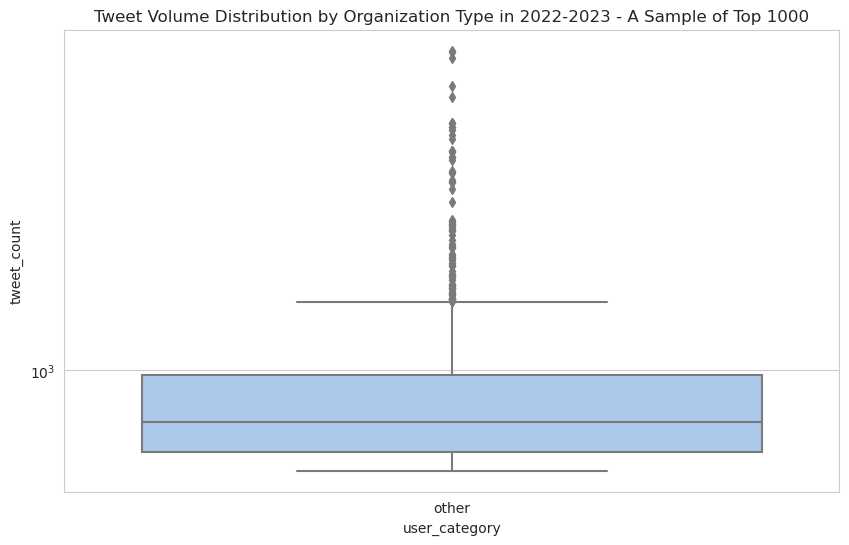

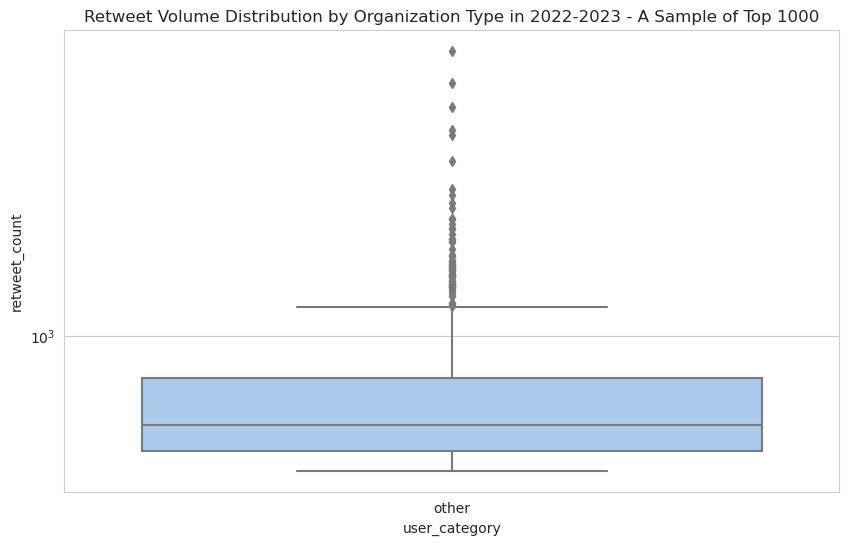

In [56]:
plt.figure(figsize=(10,6))
sns.boxplot(x='user_category', y='tweet_count', data=volume_pd_df_top1000_by_twt)
plt.yscale('log')
plt.title('Tweet Volume Distribution by Organization Type in 2022-2023 - A Sample of Top 1000')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='user_category', y='retweet_count', data=volume_pd_df_top1000_by_retwt)
plt.yscale('log')
plt.title('Retweet Volume Distribution by Organization Type in 2022-2023 - A Sample of Top 1000')
plt.show()

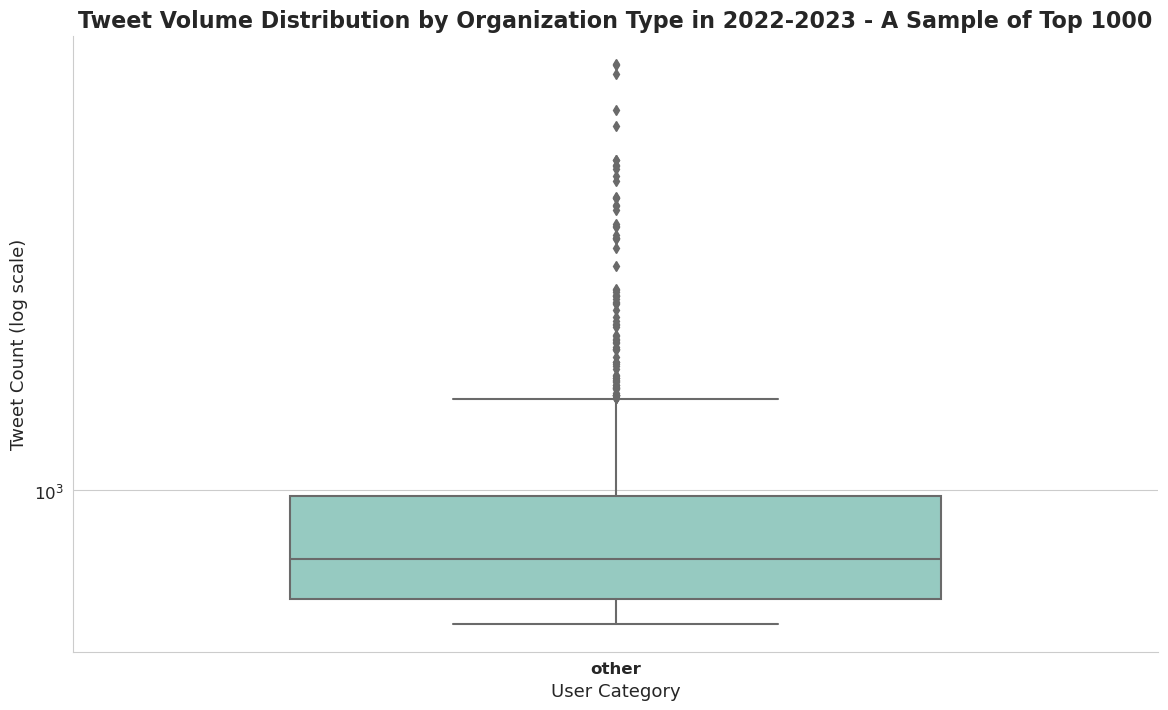

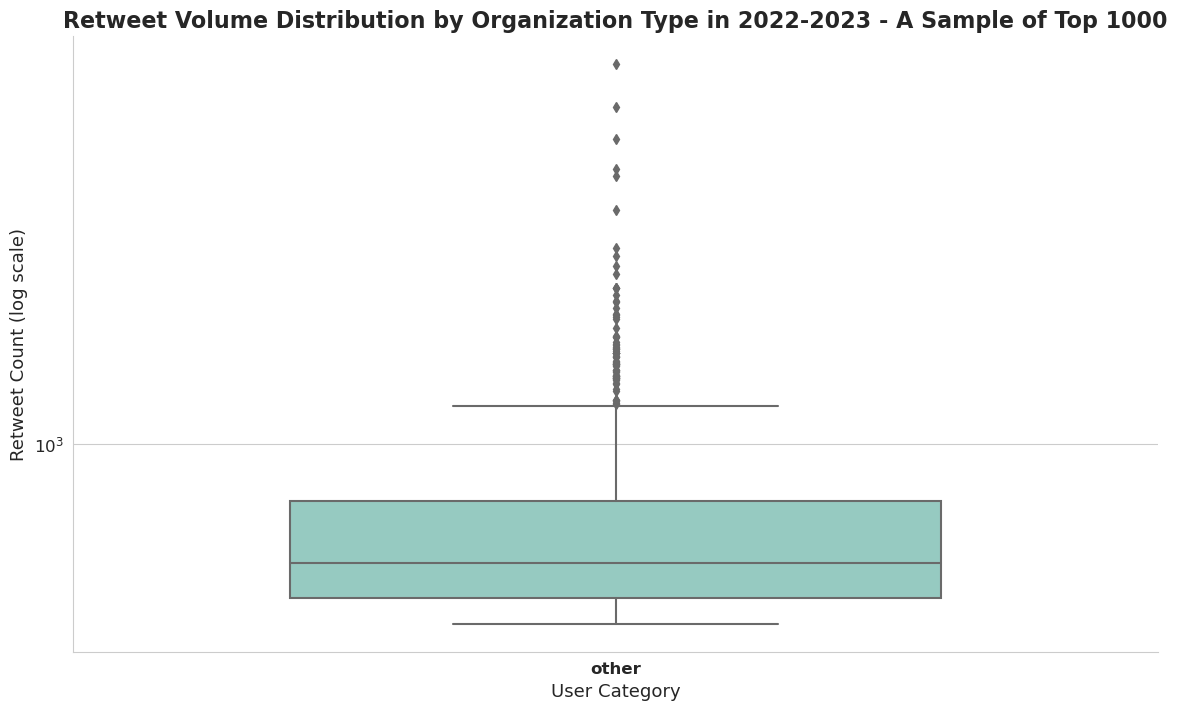

In [57]:
plt.figure(figsize=(14,8))

# Create a boxplot
sns.boxplot(x='user_category', y='tweet_count', data=volume_pd_df_top1000_by_twt, palette="Set3", width=0.6)

# Setting the scale to log
plt.yscale('log')

# Removing the top axes and right axes ticks
sns.despine()

# Giving the plot a title
plt.title('Tweet Volume Distribution by Organization Type in 2022-2023 - A Sample of Top 1000', fontsize=16, fontweight='bold')

# Labeling the axes
plt.xlabel('User Category', fontsize=13)
plt.ylabel('Tweet Count (log scale)', fontsize=13)

# Increase the fontsize and weight of the x and y tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

plt.show()

plt.figure(figsize=(14,8))

# Create a boxplot
sns.boxplot(x='user_category', y='retweet_count', data=volume_pd_df_top1000_by_retwt, palette="Set3", width=0.6)

# Setting the scale to log
plt.yscale('log')

# Removing the top axes and right axes ticks
sns.despine()

# Giving the plot a title
plt.title('Retweet Volume Distribution by Organization Type in 2022-2023 - A Sample of Top 1000', fontsize=16, fontweight='bold')

# Labeling the axes
plt.xlabel('User Category', fontsize=13)
plt.ylabel('Retweet Count (log scale)', fontsize=13)

# Increase the fontsize and weight of the x and y tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

plt.show()


In [58]:
# Count tweets by user_category
user_category_tweets_df = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == False")\
                                    .groupBy('user_category').count().withColumnRenamed('count', 'tweet_count')
user_category_tweets_df = user_category_tweets_df.orderBy(desc("tweet_count"))
user_category_tweets_df.count()

7

In [59]:
# Count retweets by user_category
user_category_retweets_df = tweets_parquet_df.filter("retweeted_status IS NOT NULL")\
                                             .groupBy('user_category').count().withColumnRenamed('count', 'retweet_count')
user_category_retweets_df = user_category_retweets_df.orderBy(desc("retweet_count"))
user_category_retweets_df

user_category,retweet_count
other,38969659
government entities,280
nonprofit_organiz...,103
universities,97
social_media_infl...,85
health_organizations,59
celebrities,9


In [60]:
# Count quoted tweets by user_category
user_category_quoted_df = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == True")\
                                         .groupBy('user_category').count().withColumnRenamed('count', 'quoted_count')
user_category_quoted_df = user_category_quoted_df.orderBy(desc("quoted_count"))
user_category_quoted_df

user_category,quoted_count
other,2806650
government entities,26
social_media_infl...,17
nonprofit_organiz...,9
universities,8
celebrities,1
health_organizations,1


In [ ]:
# Join the three dataframes
combined_df = user_category_tweets_df.join(user_category_retweets_df, on='user_category', how='outer')\
                                     .join(user_category_quoted_df, on='user_category', how='outer')
combined_df.show(5)

+--------------------+-----------+-------------+------------+
|       user_category|tweet_count|retweet_count|quoted_count|
+--------------------+-----------+-------------+------------+
|health_organizations|         93|           59|           1|
|social_media_infl...|        231|           85|          17|
|         celebrities|         10|            9|           1|
|        universities|        377|           97|           8|
|               other|   20500076|     38969659|     2806650|
+--------------------+-----------+-------------+------------+
only showing top 5 rows



In [ ]:
combined_pd_df = combined_df.toPandas()
plt_combined_pd_df = pd.melt(combined_pd_df,
                               id_vars=list(combined_pd_df.columns[0:1]),
                               value_vars=list(combined_pd_df.columns[1:]),
                               var_name='type_of_tweet',
                               value_name='tweet_count')
plt_combined_pd_df.head(5)

/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,user_category,type_of_tweet,tweet_count
0,health_organizations,tweet_count,93
1,social_media_influencers,tweet_count,231
2,celebrities,tweet_count,10
3,universities,tweet_count,377
4,other,tweet_count,20500076


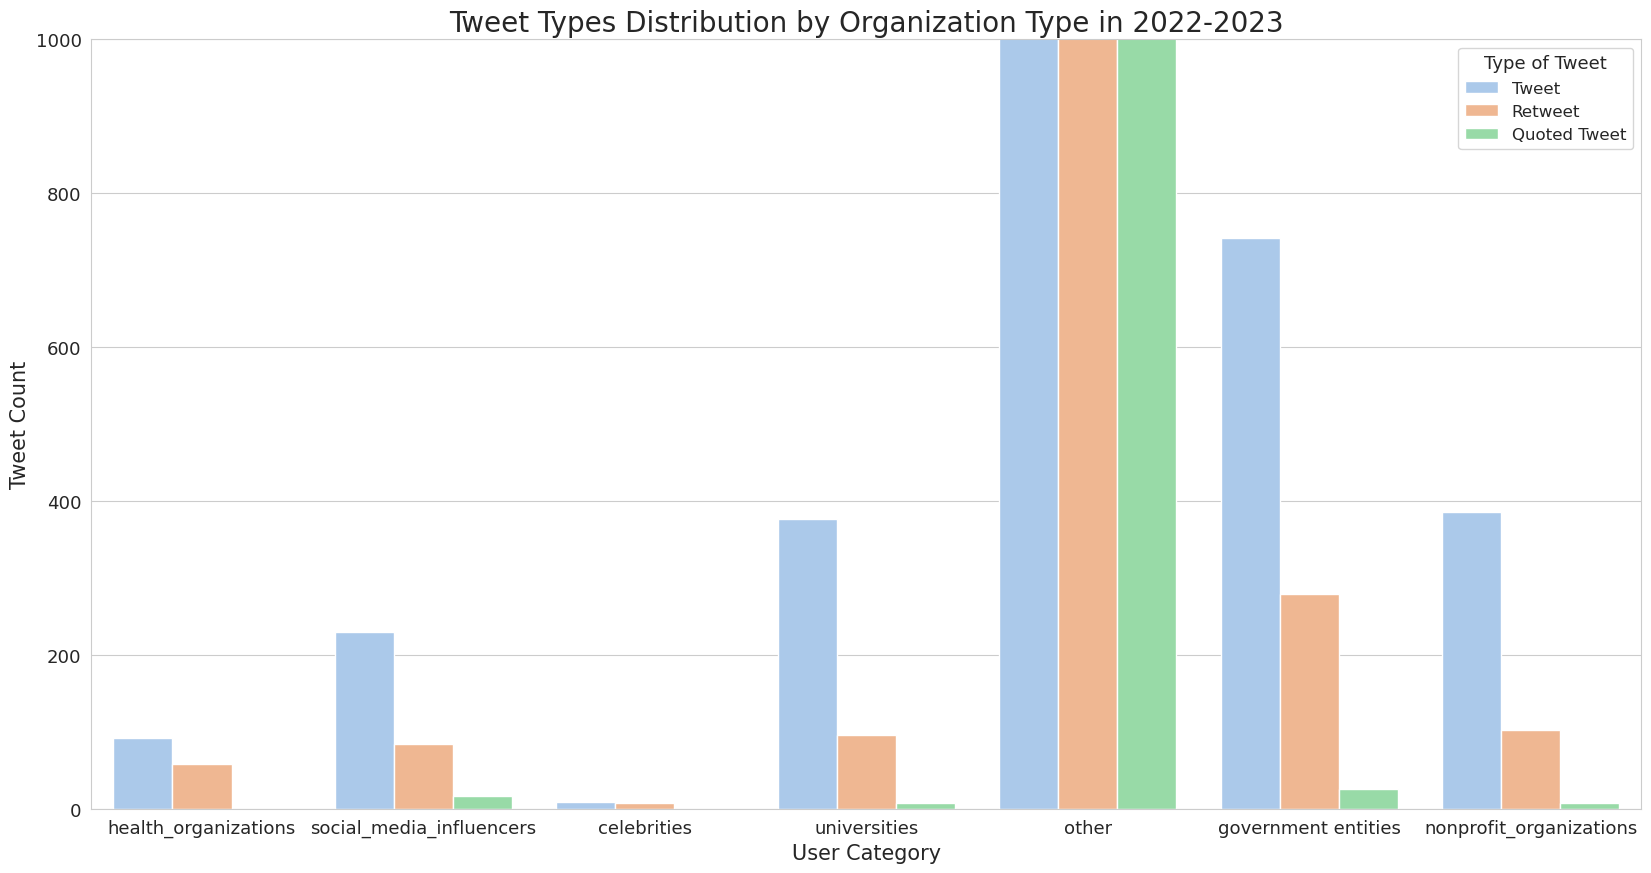

In [ ]:
# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")


plt.figure(figsize=(20, 10))

# Create the bar plot
bar_plot = sns.barplot(x='user_category', y='tweet_count', hue='type_of_tweet', data=plt_combined_pd_df, ci=None)

# Add title and labels with custom font sizes
plt.title('Tweet Types Distribution by Organization Type in 2022-2023', fontsize=20)
plt.xlabel('User Category', fontsize=15)
plt.ylabel('Tweet Count', fontsize=15)

# Limit the y-axis
plt.ylim(0, 1000)

# Customize the legend
legend = plt.legend(title='Type of Tweet', title_fontsize='13', fontsize='12')

new_labels = ['Tweet', 'Retweet', 'Quoted Tweet']  
for t, l in zip(legend.texts, new_labels): 
    t.set_text(l)

# Increase the tick label size
bar_plot.tick_params(labelsize=13)

# Show the plot
plt.show()


### 4.3 Analysis by Location

In [52]:
# Group by user location and count the number of tweets from each location
#location_df = tweets_parquet_df.filter(col('user_location').isNotNull())\
#                               .groupBy('user_location').count().orderBy('count', ascending=False)
location_df = tweets_parquet_df.select('user_location').filter(col('user_location').isNotNull())
location_df.count()

37757830

In [38]:
location_df.show(10)

+--------------------+
|       user_location|
+--------------------+
|         Philippines|
|East Midlands, En...|
|Sunny and Free Fl...|
|         Kansas, USA|
|           Indonesia|
|         Nevada, USA|
|          $MoZygote |
|     Decelis Academy|
|       Riverview, FL|
|  Los Angeles County|
+--------------------+
only showing top 10 rows



In [53]:
# List all user_location contains '/' to ensure all these locations are valid addresses, not 'she/her.'

# filter rows based on this condition
filtered_df_1 = location_df.filter(col('user_location').contains('/'))

In [40]:
filtered_df_1.count()

2436866

In [41]:
filtered_df_1.show(20)

+--------------------+
|       user_location|
+--------------------+
|            She/they|
|        he/they | 28|
|USA • She/Her • 1...|
|       She/her | 16 |
|          15 she/her|
|https://gab.com/L...|
|         24 she/they|
|             he/him |
|            they/she|
|⠀ ⠀⠀ ⠀ ⠀ ⠀


⠀ ⠀⠀...|
|     edtwt/vent | 17|
|OC/San Diego/Aust...|
|in ur house - s/h...|
|        they/them 17|
|             she/her|
|      fey/fem ☭ cbyf|
|she/her | 20 | st...|
|18 🎀 she/they + ...|
|Galloway/Gall-Ghà...|
|      She/They/He :)|
+--------------------+
only showing top 20 rows



In [54]:
# remove out all locations with '/'
location_df = location_df.filter(~col('user_location').contains('/') 
                                 & ~col('user_location').contains('$')
                                 & ~col('user_location').contains('Earth'))

In [46]:
location_df.show(20)

+--------------------+
|       user_location|
+--------------------+
|         Philippines|
|East Midlands, En...|
|Sunny and Free Fl...|
|         Kansas, USA|
|           Indonesia|
|         Nevada, USA|
|     Decelis Academy|
|       Riverview, FL|
|  Los Angeles County|
|          Luxembourg|
|             Ukraine|
|        Bay Area, CA|
|             Ireland|
|     Alberta, Canada|
|    Barcelona, Spain|
|           Macon, GA|
|          west coast|
|       Manhattan, NY|
|    Williamstown, MA|
|            Bradford|
+--------------------+
only showing top 20 rows



In [ ]:
location_df.count()

35320964

In [55]:
from pyspark.sql.functions import split, isnull, instr

# Split the user_location column into two separate columns based on the presence of a comma
location_df = location_df.withColumn('city_or_state', 
                                     when(instr(col('user_location'), ',') > 0, split(col('user_location'), ',').getItem(0))
                                     .otherwise(col('user_location')))

location_df = location_df.withColumn('country_raw', 
                                     when(instr(col('user_location'), ',') > 0, split(col('user_location'), ',').getItem(1))
                                     .otherwise(col('user_location')))

location_df.show(20)


+--------------------+--------------------+--------------------+
|       user_location|       city_or_state|         country_raw|
+--------------------+--------------------+--------------------+
|         Philippines|         Philippines|         Philippines|
|East Midlands, En...|       East Midlands|             England|
|Sunny and Free Fl...|Sunny and Free Fl...|Sunny and Free Fl...|
|         Kansas, USA|              Kansas|                 USA|
|           Indonesia|           Indonesia|           Indonesia|
|         Nevada, USA|              Nevada|                 USA|
|     Decelis Academy|     Decelis Academy|     Decelis Academy|
|       Riverview, FL|           Riverview|                  FL|
|  Los Angeles County|  Los Angeles County|  Los Angeles County|
|          Luxembourg|          Luxembourg|          Luxembourg|
|             Ukraine|             Ukraine|             Ukraine|
|        Bay Area, CA|            Bay Area|                  CA|
|             Ireland|   

In [56]:
from pyspark.sql.functions import trim

# Define standardization rules
location_df = location_df.withColumn(
    'country',
    when(trim(col('country_raw')) == 'USA', 'United States')
    .when(trim(col('country_raw')) == 'U.S.A.', 'United States')
    .when(trim(col('country_raw')) == 'US', 'United States')
    .when(trim(col('country_raw')) == 'NYC', 'United States')
    .when(trim(col('country_raw')) == 'OR', 'United States')
    .when(trim(col('country_raw')) == 'OK', 'United States')
    .when(trim(col('country_raw')) == 'NV', 'United States')
    .when(trim(col('country_raw')) == 'IL', 'United States')
    .when(trim(col('country_raw')) == 'CA', 'United States')
    .when(trim(col('country_raw')) == 'NY', 'United States')
    .when(trim(col('country_raw')) == 'FL', 'United States')
    .when(trim(col('country_raw')) == 'TX', 'United States')
    .when(trim(col('country_raw')) == 'DC', 'United States')
    .when(trim(col('country_raw')) == 'GA', 'United States')
    .when(trim(col('country_raw')) == 'PA', 'United States')
    .when(trim(col('country_raw')) == 'Texas', 'United States')
    .when(trim(col('country_raw')) == 'NC', 'United States')
    .when(trim(col('country_raw')) == 'NJ', 'United States')
    .when(trim(col('country_raw')) == 'OH', 'United States')
    .when(trim(col('country_raw')) == 'Tx', 'United States')
    .when(trim(col('country_raw')) == 'VA', 'United States')
    .when(trim(col('country_raw')) == 'WA', 'United States')
    .when(trim(col('country_raw')) == 'MA', 'United States')
    .when(trim(col('country_raw')) == 'TN', 'United States')
    .when(trim(col('country_raw')) == 'MI', 'United States')
    .when(trim(col('country_raw')) == 'MD', 'United States')
    .when(trim(col('country_raw')) == 'IN', 'United States')
    .when(trim(col('country_raw')) == 'MN', 'United States')
    .when(trim(col('country_raw')) == 'MO', 'United States')
    .when(trim(col('country_raw')) == 'LA', 'United States')
    .when(trim(col('country_raw')) == 'WI', 'United States')
    .when(trim(col('country_raw')) == 'ON', 'United States')
    .when(trim(col('country_raw')) == 'AZ', 'United States')
    .when(trim(col('country_raw')) == 'AL', 'United States')
    .when(trim(col('country_raw')) == 'KY', 'United States')
    .when(trim(col('country_raw')) == 'SC', 'United States')
    .when(trim(col('country_raw')) == 'California', 'United States')
    .when(trim(col('country_raw')) == 'New York', 'United States')
    .when(trim(col('country_raw')) == 'Ohio', 'United States')
    .when(trim(col('country_raw')) == 'CO', 'United States')  
    .when(trim(col('country_raw')) == 'Ca', 'United States')  
    .when(trim(col('country_raw')) == 'tx', 'United States')  
    .when(trim(col('country_raw')) == 'IA', 'United States') 
    .when(trim(col('country_raw')) == 'Virginia', 'United States')  
    .when(trim(col('country_raw')) == 'Florida', 'United States')  
    .when(trim(col('country_raw')) == 'Illinois', 'United States')  
    .when(trim(col('country_raw')) == 'Indiana', 'United States')  
    .when(trim(col('country_raw')) == 'Georgia', 'United States') 
    .when(trim(col('country_raw')) == 'west coast', 'United States') 
    .when(trim(col('country_raw')) == 'Los Angeles County', 'United States') 
    .when(trim(col('country_raw')) == 'UK', 'United Kingdom')
    .when(trim(col('country_raw')) == 'England', 'United Kingdom') 
    .when(trim(col('country_raw')) == 'London', 'United Kingdom') 
    .when(trim(col('country_raw')) == 'Ontario', 'Canada') 
    .otherwise(trim(col('country_raw')))  # if no rule applies, keep the original location
)


location_df.show(10)

+--------------------+--------------------+--------------------+--------------------+
|       user_location|       city_or_state|         country_raw|             country|
+--------------------+--------------------+--------------------+--------------------+
|         Philippines|         Philippines|         Philippines|         Philippines|
|East Midlands, En...|       East Midlands|             England|      United Kingdom|
|Sunny and Free Fl...|Sunny and Free Fl...|Sunny and Free Fl...|Sunny and Free Fl...|
|         Kansas, USA|              Kansas|                 USA|       United States|
|           Indonesia|           Indonesia|           Indonesia|           Indonesia|
|         Nevada, USA|              Nevada|                 USA|       United States|
|     Decelis Academy|     Decelis Academy|     Decelis Academy|     Decelis Academy|
|       Riverview, FL|           Riverview|                  FL|       United States|
|  Los Angeles County|  Los Angeles County|  Los Angel

#### 4.3.1 Visualization by Country

In [83]:
# Re-group by country
location_by_country_df = location_df.groupBy('country').count().orderBy('count', ascending=False)

In [18]:
location_by_country_df.count()

1917988

In [84]:
location_by_country_pd_df = location_by_country_df.limit(10).toPandas()

In [56]:
location_by_country_pd_df

,country,count
0,United States,10276612
1,United Kingdom,1416210
2,Nigeria,939712
3,India,880564
4,Canada,601746
5,South Africa,315234
6,Kenya,225779
7,Pakistan,177069
8,Ghana,155193
9,Australia,152016


In [27]:
# Ensure Plotly is updated to the latest version
!pip install plotly --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 62.1 MB/s eta 0:00:0000:0100:01


In [69]:
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.1 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=ea07e77deca1a0b1843ebedc5e059e0c46ee770dc9959dcfb8630572e9acfbe1
  Stored in directory: /root/.cache/pip/wheels/e2/aa/0f/c224e473b464387170b83ca7c66947b4a7e33e8d903a679748
Successfully built pycountry


In [79]:
!pip install pycountry_convert

In [100]:
#!pip install psutil nbformat ipywidgets jupyterlab

In [30]:
import plotly.io as pio
pio.renderers.default='notebook'

In [85]:
import pycountry
import pycountry_convert as pc

def country_to_iso_alpha(country_name):
    try:
        return pycountry.countries.get(name=country_name).alpha_3
    except AttributeError:
        print(f"'{country_name}' not found in the country list.")
        return None

location_by_country_pd_df['iso_alpha'] = location_by_country_pd_df['country'].apply(country_to_iso_alpha)
location_by_country_pd_df


# Function to convert country name to 2-letter ISO code
def country_to_alpha2(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_2
    except:
        return None

# Function to convert 2-letter ISO code to continent
def alpha2_to_continent(alpha2_code):
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(alpha2_code)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None
    
def alpha2_to_continent(country_name):
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(country_to_alpha2(country_name))
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None

# Convert 'United States' to 2-letter ISO code
#usa_alpha2 = country_to_alpha2('United States')

# Convert 2-letter ISO code to continent
#usa_continent = alpha2_to_continent(usa_alpha2)

#print(f'The United States is in {usa_continent}.')

location_by_country_pd_df['iso_alpha'] = location_by_country_pd_df['country'].apply(country_to_iso_alpha)
location_by_country_pd_df['continent'] = location_by_country_pd_df['iso_alpha'].apply(alpha2_to_continent)
location_by_country_pd_df


,country,count,iso_alpha,continent
0,United States,10566514,USA,North America
1,United Kingdom,1415923,GBR,Europe
2,Nigeria,939665,NGA,Africa
3,India,880534,IND,Asia
4,Canada,601564,CAN,North America
5,South Africa,315208,ZAF,Africa
6,Kenya,225777,KEN,Africa
7,Pakistan,177068,PAK,Asia
8,Ghana,155193,GHA,Africa
9,Australia,151965,AUS,Oceania


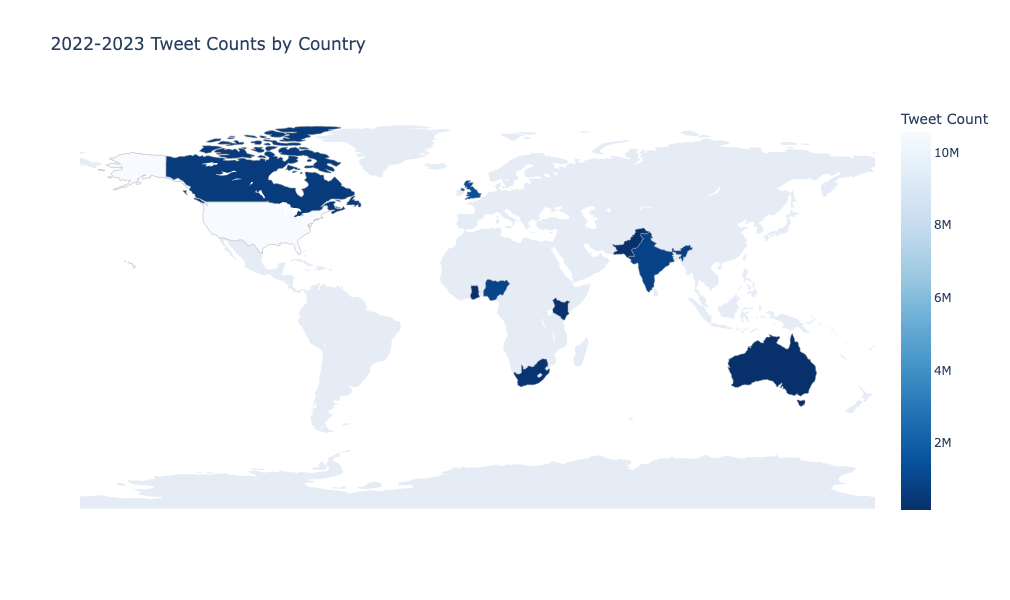

In [79]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=location_by_country_pd_df['iso_alpha'],  # dataframe column with country ISO Alpha
    z=location_by_country_pd_df['count'].astype(float),  # data to be color-coded
    text=location_by_country_pd_df['country'],  # data displayed when hovering over
    colorscale='Blues',  # color scale
    autocolorscale=False,  # allow automatic color scale
    reversescale=True,  # reverse color scale
    marker_line_color='darkgray',  # color of marker lines
    marker_line_width=0.5,  # width of marker lines
    colorbar_title='Tweet Count',  # color bar title
))

fig.update_layout(
    title_text='2022-2023 Tweet Counts by Country',  # title of plot
    width=800,
    height=600,
    geo=dict(
        showframe=False,  # no bounding frame
        showcoastlines=False,  # show coastlines
        projection_type='equirectangular'  # projection type
    )
)

fig.show()


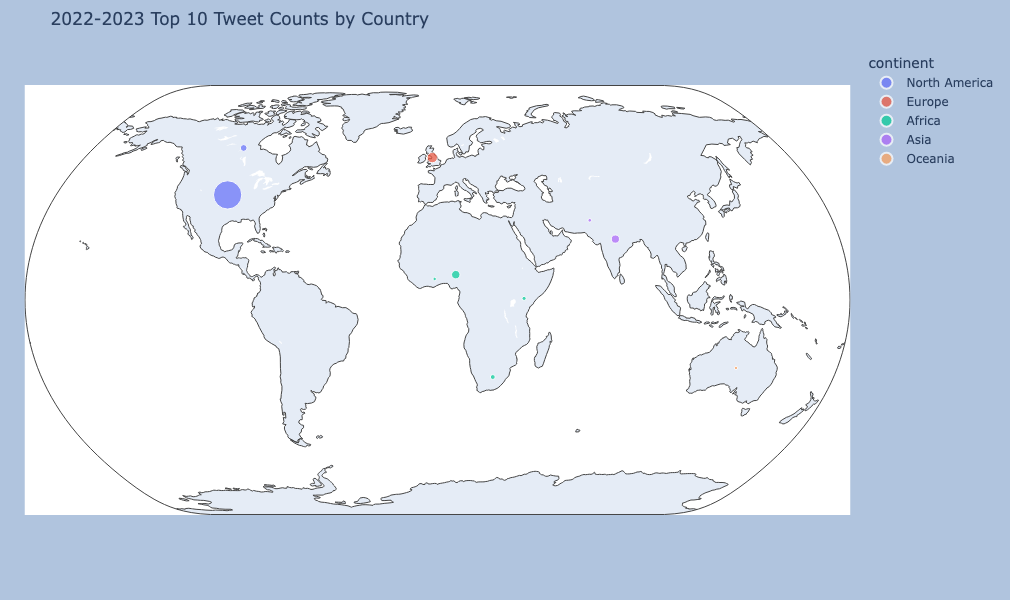

In [38]:
import plotly.express as px

fig = px.scatter_geo(location_by_country_pd_df, 
                     locations="iso_alpha", 
                     color="continent",
                     hover_name="country", 
                     size="count",
                     projection="natural earth",
                     color_continuous_scale=px.colors.sequential.Plasma, # Change the color scale
                     title='2022-2023 Top 10 Tweet Counts by Country',  # Add a title
                     )

# Enhance hover data
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br><br>" +
                  "Continent: %{marker.color}<br>" +
                  "Count: %{marker.size}<br>" +
                  "<extra></extra>"
)

# Customize the layout
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    margin=dict(l=25, r=25, b=50, t=50, pad=4),
    paper_bgcolor="LightSteelBlue",  # Change the background color
)

fig.show()


#### 4.3.2 Visualization in US

In [58]:
# Re-group by US
location_by_us_df = location_df.filter((col('country')=='United States') & (col('city_or_state') != 'United States'))\
                                .groupBy('city_or_state').count().orderBy('count', ascending=False)


In [61]:
location_by_us_pd_df = location_by_us_df.limit(100).toPandas()
location_by_us_pd_df

,city_or_state,count
0,New York,332299
1,Texas,296617
2,California,289322
3,USA,248857
4,Florida,244750
...,...,...
95,US,15195
96,NC,14641
97,Durham,14619
98,Madison,14366


In [62]:
!pip install geopy

In [68]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

def get_latitude_longitude(city):
    location = geolocator.geocode(city)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

# Usage
latitude, longitude = get_latitude_longitude('New York')
print(latitude, longitude)


40.7127281 -74.0060152


In [73]:
# Apply the function to each city_or_state in the DataFrame
location_by_us_pd_df[['latitude', 'longitude']] = location_by_us_pd_df['city_or_state']\
                                                .apply(lambda x: pd.Series(get_latitude_longitude(x)))
location_by_us_pd_df

,city_or_state,count,latitude,longitude
0,New York,332299,40.712728,-74.006015
1,Texas,296617,31.263890,-98.545612
2,California,289322,36.701463,-118.755997
3,USA,248857,39.783730,-100.445882
4,Florida,244750,27.756767,-81.463983
...,...,...,...,...
95,US,15195,39.783730,-100.445882
96,NC,14641,35.672964,-79.039292
97,Durham,14619,35.996653,-78.901805
98,Madison,14366,43.074761,-89.383761


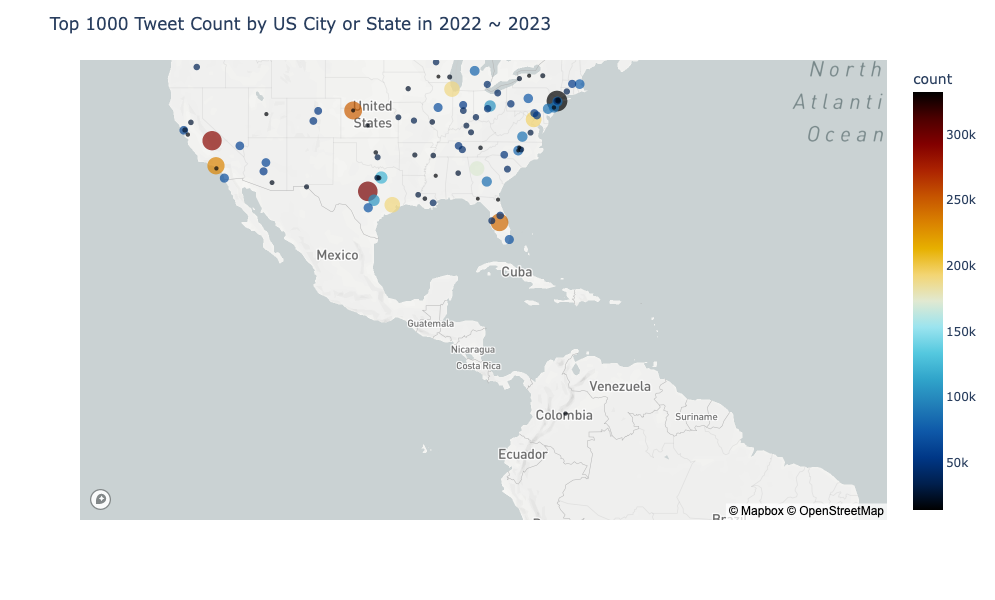

In [78]:
import plotly.express as px

# Set mapbox access token
px.set_mapbox_access_token('pk.eyJ1IjoiZXN0aGVyeHUiLCJhIjoiY2xocXpxNnc4MDV3ZzNxbXR3a24xYW5wayJ9.W-NC4WOw3O3bAm9hQF3reQ')

# Use DataFrame in the scatter_mapbox function
fig = px.scatter_mapbox(location_by_us_pd_df, lat="latitude", lon="longitude", color="count", size="count",
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=3)

# Set the title of the plot
fig.update_layout(title_text='Top 1000 Tweet Count by US City or State in 2022 ~ 2023',
                  width=800,  # Set figure width
                  height=600)  # Set figure height

# Increase the size of the hover name for better visibility
fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>Count: %{marker.size}<br>Size: %{marker.size}<extra></extra>', 
                  hovertext=location_by_us_pd_df['city_or_state'])

# Add a geo_scope, which can provide a better view of the United States
fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")

# Show the figure
fig.show()


### 4.4 Analysis by Timelines

In [ ]:
#### 4.4.1 What are the timelines of these tweets? Do you see significant peaks and valleys?

In [ ]:
#### 4.4.2 Do you see any data collection gaps?,Plot the timelines of these tweets

In [82]:
# from pyspark.sql.functions import to_date

# # Group by date and count the number of tweets
# tweets_by_date_df = tweets_parquet_df.groupBy("created_at").count().orderBy('created_at')

# tweets_by_date_df.count()

327

In [ ]:
# tweets_by_date_pd_df = tweets_by_date_df.toPandas()

In [ ]:
# Count tweets by date
user_date_tweets_df = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == False")\
                                    .groupBy('created_at').count().withColumnRenamed('count', 'tweet_count')
user_date_tweets_df = user_date_tweets_df.orderBy(desc("tweet_count"))
user_date_tweets_df.count()

327

In [90]:
# Count retweets by date
user_date_retweets_df = tweets_parquet_df.filter("retweeted_status IS NOT NULL")\
                                             .groupBy('created_at').count().withColumnRenamed('count', 'retweet_count')
user_date_retweets_df = user_date_retweets_df.orderBy(desc("retweet_count"))
user_date_retweets_df

created_at,retweet_count
2022-05-25,478521
2022-05-26,365650
2022-05-27,305892
2022-05-28,253796
2022-08-25,207143
2022-08-26,186495
2022-08-24,184833
2022-05-24,184137
2022-06-01,178167
2022-06-06,178159


In [ ]:
# Count quoted tweets by date
user_date_quoted_df = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == True")\
                                         .groupBy('created_at').count().withColumnRenamed('count', 'quoted_count')
user_date_quoted_df = user_date_quoted_df.orderBy(desc("quoted_count"))
user_date_quoted_df

created_at,quoted_count
2022-11-18,26875
2022-11-22,25057
2022-11-16,23755
2022-11-17,22681
2022-11-19,22272
2022-11-21,21740
2022-11-27,20535
2022-11-23,20456
2022-05-01,20114
2022-11-20,19963


In [ ]:
# Join the three dataframes
combined_date_df = user_date_tweets_df.join(user_date_retweets_df, on='created_at', how='outer')\
                                     .join(user_date_quoted_df, on='created_at', how='outer')
combined_date_df.show(5)

+----------+-----------+-------------+------------+
|created_at|tweet_count|retweet_count|quoted_count|
+----------+-----------+-------------+------------+
|2022-05-19|      73246|       144917|       12565|
|2022-07-27|      61407|       108970|        5997|
|2022-07-31|      48722|        76207|        5539|
|2022-08-02|      62528|       105919|        6052|
|2022-11-29|      72823|       109544|       10566|
+----------+-----------+-------------+------------+
only showing top 5 rows



In [ ]:
combined_date_pd_df = combined_date_df.toPandas()

In [ ]:
plt_combined_date_pd_df = pd.melt(combined_date_pd_df,
                               id_vars=list(combined_date_pd_df.columns[0:1]),
                               value_vars=list(combined_date_pd_df.columns[1:]),
                               var_name='type_of_tweet',
                               value_name='tweet_count')
plt_combined_date_pd_df.head(5)

/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



,created_at,type_of_tweet,tweet_count
0,2022-05-19,tweet_count,73246
1,2022-07-27,tweet_count,61407
2,2022-07-31,tweet_count,48722
3,2022-08-02,tweet_count,62528
4,2022-11-29,tweet_count,72823


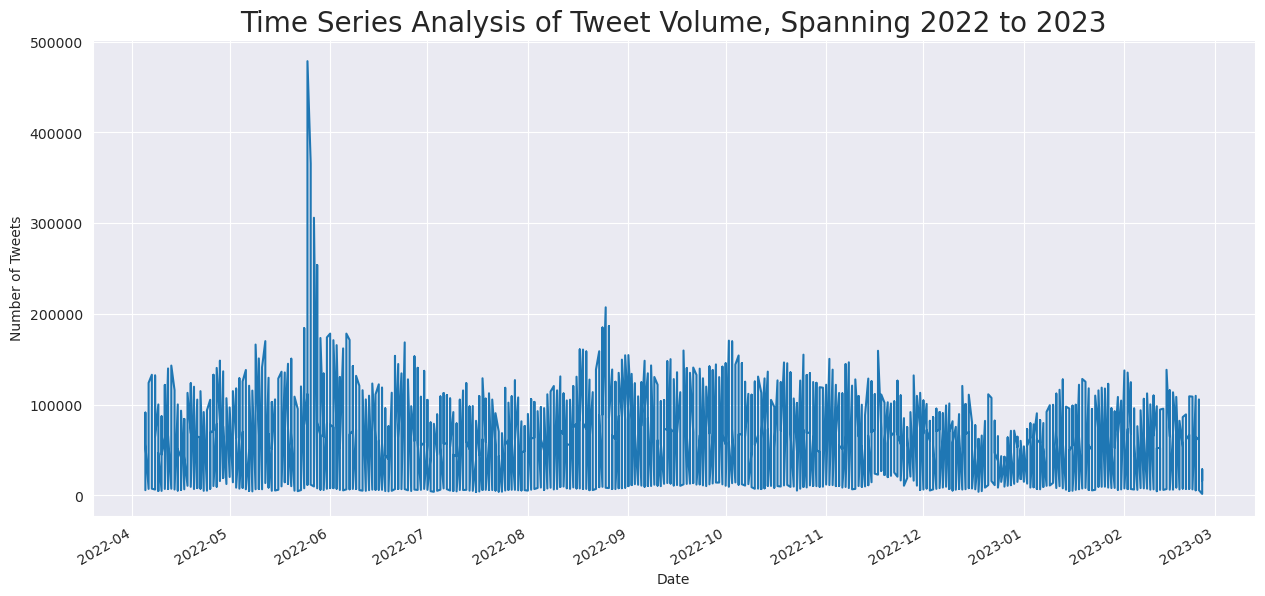

In [101]:

# Ensure that 'created_at' column is in datetime format
plt_combined_date_pd_df['created_at'] = pd.to_datetime(plt_combined_date_pd_df['created_at'])

# Sort the data by date
plt_combined_date_pd_df = plt_combined_date_pd_df.sort_values('created_at')

# Plotting
plt.figure(figsize=(15,7))  # Set the figure size
plt_combined_date_pd_df.set_index('created_at')['tweet_count'].plot()
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Time Series Analysis of Tweet Volume, Spanning 2022 to 2023',fontsize=20)
plt.show()


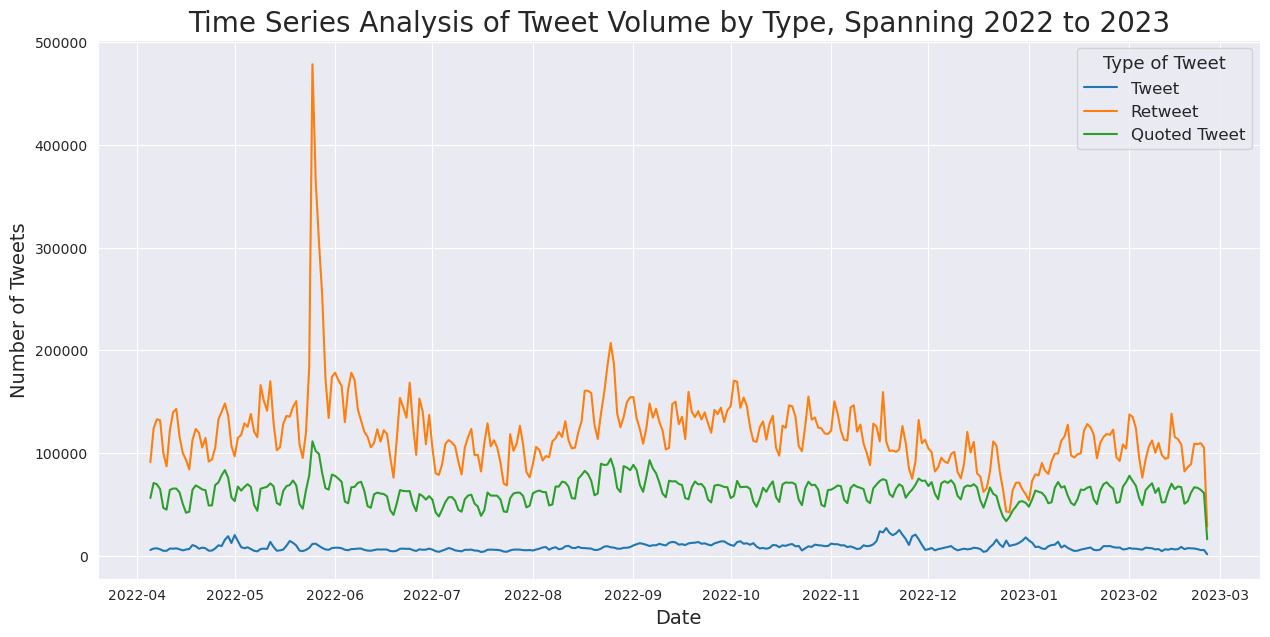

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that 'created_at' column is in datetime format
plt_combined_date_pd_df['created_at'] = pd.to_datetime(plt_combined_date_pd_df['created_at'])

# Sort the data by date
plt_combined_date_pd_df = plt_combined_date_pd_df.sort_values('created_at')

# Set the style of seaborn
sns.set_style("darkgrid")

# Set the figure size and create a subplot
fig, ax = plt.subplots(figsize=(15, 7))

# Create separate plots for each type of tweet
for tweet_type in plt_combined_date_pd_df['type_of_tweet'].unique():
    subset = plt_combined_date_pd_df[plt_combined_date_pd_df['type_of_tweet'] == tweet_type]
    sns.lineplot(data=subset, x='created_at', y='tweet_count', label=tweet_type, ax=ax)

# Set labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Tweets', fontsize=14)
ax.set_title('Time Series Analysis of Tweet Volume by Type, Spanning 2022 to 2023', fontsize=20)
#ax.legend()

# Customize the legend
legend = ax.legend(title='Type of Tweet', title_fontsize='13', fontsize='12')

new_labels = ['Tweet', 'Retweet', 'Quoted Tweet']  
for t, l in zip(legend.texts, new_labels): 
    t.set_text(l)
    

plt.show()


### 4.5 .Text Similarity Analysis

#### 4.5.1 select `Text` data and Tokenizer and Vectorizer

Due to the large size of the text dataset, it was necessary to trim it for analysis, as processing the entire dataset would exceed memory capacity. Since the average word length is around six characters, analyzing the first 50 words of an article can determine if it is a 'near duplicate.' Therefore, I trimmed the texts by taking a substring of 300 characters to reduce the dataset size.

In [39]:
from pyspark.sql.functions import substring

# Only filter the original tweets
text_raw_df = tweets_parquet_df.select("user_id","user_screen_name","hashtags","tweet_text",
                                       "user_category",substring('tweet_text',1,300))\
                               .filter("retweeted_status IS NULL AND is_quote_status == False")\
                               .withColumnRenamed("substring(tweet_text, 1, 300)","trimmed_text")

In [83]:
text_raw_df.show(2)

+-------------------+----------------+--------+--------------------+-------------+--------------------+
|            user_id|user_screen_name|hashtags|          tweet_text|user_category|        trimmed_text|
+-------------------+----------------+--------+--------------------+-------------+--------------------+
|1427744719837097984| gworlinterupted|      []|should i drop out...|        other|should i drop out...|
| 982698102984339458|    sparklexosvt|      []|@collegemenfess e...|        other|@collegemenfess e...|
+-------------------+----------------+--------+--------------------+-------------+--------------------+
only showing top 2 rows



In [11]:
text_raw_df.count()

20501915

In [13]:
# Randomly sampling 0.3% of the data，due to the computational complexity

sampled_df = text_raw_df.sample(withReplacement=False, fraction=0.003, seed=100)

In [12]:
sampled_df.count()

61436

In [14]:
from pyspark.sql.functions import lower,regexp_replace,col

# Convert to lower case
sampled_df = sampled_df.withColumn("trimmed_text", lower(col("trimmed_text")))

In [15]:
# Remove special characters
sampled_df = sampled_df.withColumn("trimmed_text", regexp_replace("trimmed_text", "[^a-zA-Z\\s]", ""))
sampled_df.show(5)

+-------------------+----------------+--------+--------------------+-------------+--------------------+
|            user_id|user_screen_name|hashtags|          tweet_text|user_category|        trimmed_text|
+-------------------+----------------+--------+--------------------+-------------+--------------------+
|1537083346173407232|     foresshadow|      []|going to school ?...|        other|going to school  ...|
|          345620436|     _DebbieDebs|      []|@thelastnara Took...|        other|thelastnara took ...|
|          370944917|   DCoryReynolds|      []|@therecount Some ...|        other|therecount some n...|
| 703906003788689408|       penis2let|      []|When I was young,...|        other|when i was young ...|
|         1193456473|   Carmarthenish|      []|@janforindy2 Slig...|        other|janforindy slight...|
+-------------------+----------------+--------+--------------------+-------------+--------------------+
only showing top 5 rows



In [6]:
temp_path = f"gs://{bucket_write}/shared_data/estherxu/text"

In [17]:
sampled_df.write.format("parquet").mode('overwrite').save(temp_path)

In [7]:
sampled_df = spark.read.parquet(temp_path)

In [8]:
import re

texts = sampled_df.rdd.map(lambda x : x['trimmed_text']).filter(lambda x: x is not None)
                        
text_tokens = (texts.map(lambda document: document.strip())
                   .map(lambda document: re.split(" ", document))
                   .map(lambda word: [x for x in word if len(x) > 1])
                   .zipWithIndex())


In [20]:
# Convert tokens to Spark DataFrame
text_df_tokens = spark.createDataFrame(text_tokens, ["list_of_words","id"]) 
text_df_tokens.count()

61436

In [21]:
# Drop recods with no tokens
text_df_tokens = text_df_tokens.where(col("list_of_words").getItem(0).isNotNull())

In [22]:
from pyspark.sql import Row

# Create a DataFrame with texts and their IDs
text_row = Row('trimmed_text') 
text_df=texts.map(text_row).zipWithIndex().toDF(['trimmed_text','id'])

In [23]:
from pyspark.ml.feature import CountVectorizer

# Count Vectorizer
text_vectorizer = CountVectorizer(inputCol = "list_of_words", outputCol = "features", minDF = 1.0) 
text_df_vectorized = text_vectorizer.fit(text_df_tokens).transform(text_df_tokens) 
text_df_vectorized.show(5)

23/05/18 11:45:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1779.3 KiB


+--------------------+---+--------------------+
|       list_of_words| id|            features|
+--------------------+---+--------------------+
|[coaching, centre...|  0|(126207,[1,5,9,21...|
|[beaneaterb, they...|  1|(126207,[3,12,15,...|
|[which, is, worse...|  2|(126207,[8,25,35,...|
|[johnnyr, tmorell...|  3|(126207,[0,1,2,8,...|
|[httpstcodmoablpz...|  4|(126207,[0,423,59...|
+--------------------+---+--------------------+
only showing top 5 rows



#### 4.5.2 Jaccard Similarity Comparison - Fit MinHashLSH for hash table

In [24]:
from pyspark.ml.feature import MinHashLSH

text_mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5) 

In [25]:
text_model = text_mh.fit(text_df_vectorized)

In [26]:
text_df_hashed = text_model.transform(text_df_vectorized).cache() 

In [57]:
text_df_hashed.show(5)

23/05/18 02:27:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1806.0 KiB


+--------------------+---+--------------------+--------------------+
|       list_of_words| id|            features|              hashes|
+--------------------+---+--------------------+--------------------+
|[coaching, centre...|  0|(126207,[1,5,9,21...|[[2.09418533E8], ...|
|[beaneaterb, they...|  1|(126207,[3,12,15,...|[[2.35661917E8], ...|
|[which, is, worse...|  2|(126207,[8,25,35,...|[[1.04460723E8], ...|
|[johnnyr, tmorell...|  3|(126207,[0,1,2,8,...|[[4.7945584E7], [...|
|[httpstcodmoablpz...|  4|(126207,[0,423,59...|[[4.7945584E7], [...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



In [27]:
# Join the original DataFrame with the hashed DataFrame on "id"
text_df_hashed_combined = text_df.join(text_df_hashed, "id", how = "left").cache() 
text_df_hashed_combined.show(5)

23/05/18 11:45:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1809.7 KiB
23/05/18 11:45:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1844.2 KiB


+----+--------------------+--------------------+--------------------+--------------------+
|  id|        trimmed_text|       list_of_words|            features|              hashes|
+----+--------------------+--------------------+--------------------+--------------------+
|  26|{went to the scho...|[went, to, the, s...|(126207,[0,1,2,5,...|[[3.8361494E7], [...|
|  29|{cryptonikole and...|[cryptonikole, an...|(126207,[0,2,4,7,...|[[4.7945584E7], [...|
| 474|{btstwtjungkk sho...|[btstwtjungkk, sh...|(126207,[6,9,101,...|[[4.65322979E8], ...|
| 964|{prochara and tha...|[prochara, and, t...|(126207,[0,2,4,27...|[[1.8678956E7], [...|
|1677|{graduation seaso...|[graduation, seas...|(126207,[1,5,21,4...|[[2.86621337E8], ...|
+----+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



#### 4.5.3 Jaccard Similarity Comparison - Calculate jaccard distance and return near-duplicate record

#### Perform approximate similarity join based on the given Jaccard distance threshold

In [28]:
from pyspark.ml.feature import MinHashLSHModel 
from pyspark.sql import DataFrame
from typing import Tuple
import string
def approx_similarity_join(model: MinHashLSHModel, 
                           df_hash: DataFrame,
                           col_name: string,
                           jaccard_distance: float) -> Tuple[int, int, int, DataFrame]:
    jaccard_compare = model.approxSimilarityJoin(df_hash, df_hash,jaccard_distance)\
                           .filter("datasetA.id < datasetB.id")\
                           .select(col("distCol"),
                                   col("datasetA.id").alias("id_A"), 
                                   col("datasetB.id").alias("id_B"), 
                                   col(f"datasetA.{col_name}").alias(f"{col_name}_A"), 
                                   col(f"datasetB.{col_name}").alias(f"{col_name}_B"))
    jaccard_compare.cache()
    total_count = df_hash.count()
    dups_count = jaccard_compare.select('id_A').distinct().count() 
    uniques_count = total_count - dups_count
    return total_count, dups_count, uniques_count, jaccard_compare


In [29]:
#### Initial some parameters

# Determine Jaccard Distance
jaccard_distance_30 = 0.3 
jaccard_distance_50 = 0.5 
jaccard_distance_70 = 0.7

col_name_text = "trimmed_text"

#### Build a bar-chart function for two variables of each single Jaccard Distance(count of unique and count of “near-duplicate” articles)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_unique_duplicate(duplicate_count: int,
                              unique_count: int,
                              col_name: string,
                              jaccard_distance: float):
    
    dups_df = pd.DataFrame.from_dict({'near_duplicate': [duplicate_count], 
                                           'unique': [unique_count]})\
                          .reset_index().melt(id_vars='index', var_name='type', value_name='count')

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=dups_df, x='type', y='count')
    ax.set_title(f'Twitter trimmed text duplication: Jaccard distance = {jaccard_distance}', fontsize=15)
    ax.set_xlabel("Duplicates vs. Uniques")
    ax.set_ylabel("Number of Near-Duplications")

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

#### Build a histogram showing the overall distribution of `Near-Duplication`

In [31]:
def plot_his_overall_duplicate(duplicate_count_30: int,
                               duplicate_count_50: int,
                               duplicate_count_70: int):

    thresholds = [jaccard_distance_30, jaccard_distance_50, jaccard_distance_70]
    duplications = [duplicate_count_30, duplicate_count_50, duplicate_count_70]

    sns.set(style='darkgrid')
    ax = sns.barplot(x=thresholds, y=duplications)
    ax.set_title('LSH Distribution of Overall Near-Duplication', fontsize=15)
    ax.set_xlabel("Jaccard distance")
    ax.set_ylabel("Number of Near-Duplications")

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

#### Select a sample of Jaccard comparison records across three thresholds`

In [32]:
from pyspark.sql.functions import when

def get_jaccard_compare_sample(jaccard_compare_30: DataFrame,
                               jaccard_compare_50: DataFrame,
                               jaccard_compare_70: DataFrame,
                               col_name: string):
    df_dups_30_id = jaccard_compare_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
    df_dups_50_id = jaccard_compare_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
    df_dups_70_id = jaccard_compare_70.select(col(f'{col_name}_A'), col(f'{col_name}_B'),
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

    df_dups_combined = df_dups_70_id.join(df_dups_50_id, 
                                        on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & 
                                            (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), 
                                        how="left_outer")\
                                    .join(df_dups_30_id, 
                                        on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & 
                                            (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), 
                                        how="left_outer")
    
    df_dups_combined = df_dups_combined\
                            .withColumn("threshold_30",when(col("id_30_A").isNotNull(), "Duplicate").otherwise("Non-Dup"))\
                            .withColumn("threshold_50",when(col("id_50_A").isNotNull(), "Duplicate").otherwise("Non-Dup"))\
                            .withColumn("threshold_70",when(col("id_70_A").isNotNull(), "Duplicate").otherwise("Non-Dup"))\
                            .drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')
    
    return df_dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)\
           .union(df_dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10))\
           .union(df_dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10))\
           .orderBy('threshold_30', 'threshold_50', 'threshold_70').toPandas()

##### 4.5.3.1 Jaccard Distance = 0.3 

In [33]:
text_total_count,text_dups_count_30,text_uniques_count_30, text_jaccard_compare_30 = approx_similarity_join(text_model, text_df_hashed_combined, col_name_text ,jaccard_distance_30)

23/05/18 11:45:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1840.8 KiB
23/05/18 11:45:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1877.9 KiB
23/05/18 11:45:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2018.2 KiB
23/05/18 11:48:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1896.8 KiB
23/05/18 11:48:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1903.8 KiB


In [70]:
print(f"Total records: {text_total_count}")
print(f"Duplicate texts based on {jaccard_distance_30} Jaccard distance: {text_dups_count_30}") 
print(f"Unique texts based on {jaccard_distance_30} Jaccard distance: {text_uniques_count_30}")

Total records: 61436
Duplicate texts based on 0.3 Jaccard distance: 1742
Unique texts based on 0.3 Jaccard distance: 59694


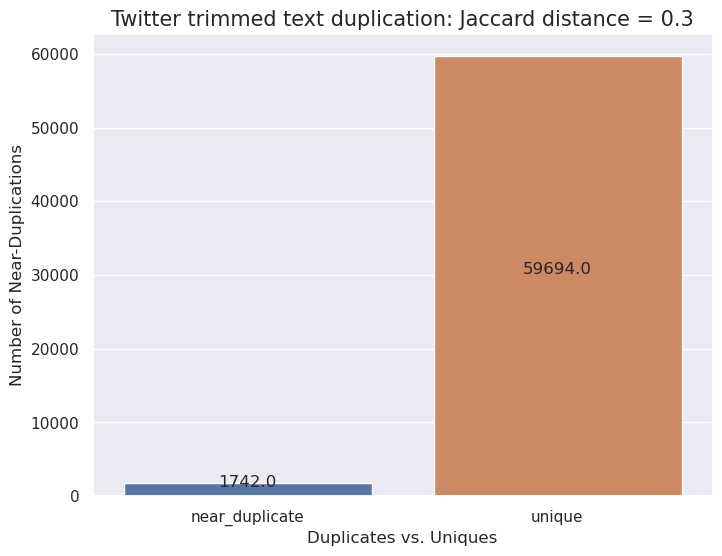

In [92]:
# Plot Bar-chart
plot_bar_unique_duplicate(text_dups_count_30,text_uniques_count_30,col_name_text,jaccard_distance_30)

##### 4.5.3.2 Jaccard Distance = 0.5 

In [34]:
text_total_count,text_dups_count_50,text_uniques_count_50, text_jaccard_compare_50 =\
        approx_similarity_join(text_model, text_df_hashed_combined, col_name_text ,jaccard_distance_50)

23/05/18 11:48:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1840.8 KiB
23/05/18 11:48:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1877.9 KiB
23/05/18 11:48:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2018.2 KiB
23/05/18 11:51:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1896.8 KiB
23/05/18 11:51:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1903.8 KiB


In [ ]:
print(f"Total records: {text_total_count}")
print(f"Duplicate titles based on {jaccard_distance_50} Jaccard distance: {text_dups_count_50}") 
print(f"Unique titles based on {jaccard_distance_50} Jaccard distance: {text_uniques_count_50}")

Total records: 61436
Duplicate titles based on 0.5 Jaccard distance: 2560
Unique titles based on 0.5 Jaccard distance: 58876


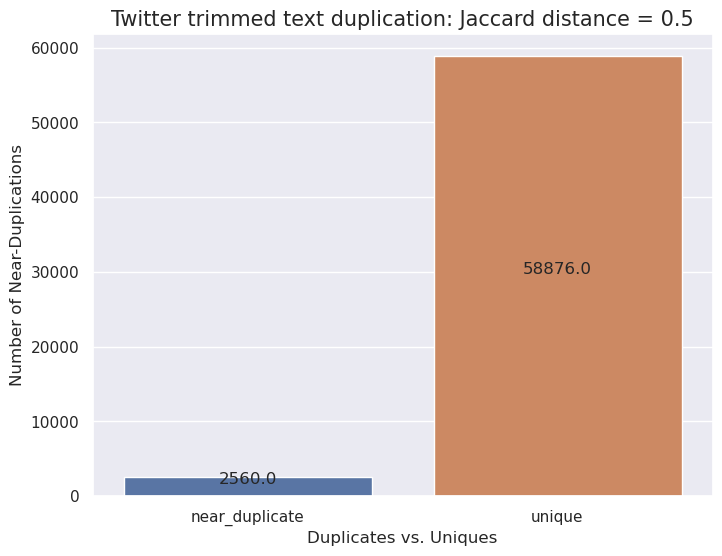

In [93]:
# Plot Bar-chart
plot_bar_unique_duplicate(text_dups_count_50,text_uniques_count_50,col_name_text,jaccard_distance_50)

##### 4.5.3.3 Jaccard Distance = 0.7 

In [35]:
text_total_count,text_dups_count_70,text_uniques_count_70, text_jaccard_compare_70 =\
        approx_similarity_join(text_model, text_df_hashed_combined, col_name_text,jaccard_distance_70)

23/05/18 11:51:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1840.8 KiB
23/05/18 11:51:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1877.9 KiB
23/05/18 11:51:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2018.2 KiB
23/05/18 11:53:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1896.8 KiB
23/05/18 11:53:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1903.8 KiB


In [ ]:
print(f"Total records: {text_total_count}")
print(f"Duplicate titles based on {jaccard_distance_70} Jaccard distance: {text_dups_count_70}") 
print(f"Unique titles based on {jaccard_distance_70} Jaccard distance: {text_uniques_count_70}")

Total records: 61436
Duplicate titles based on 0.7 Jaccard distance: 9686
Unique titles based on 0.7 Jaccard distance: 51750


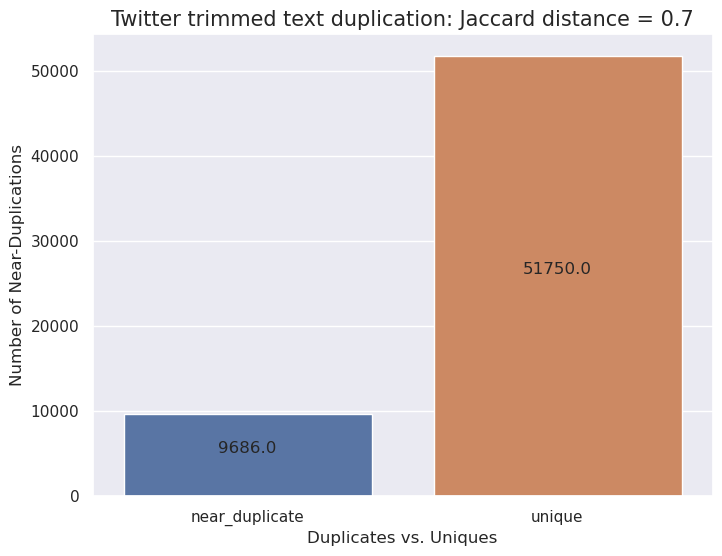

In [94]:
# Plot Bar-chart
plot_bar_unique_duplicate(text_dups_count_70,text_uniques_count_70,col_name_text,jaccard_distance_70)

##### 4.5.3.4 Build a histogram showing the overall distribution of `Near-Duplication`

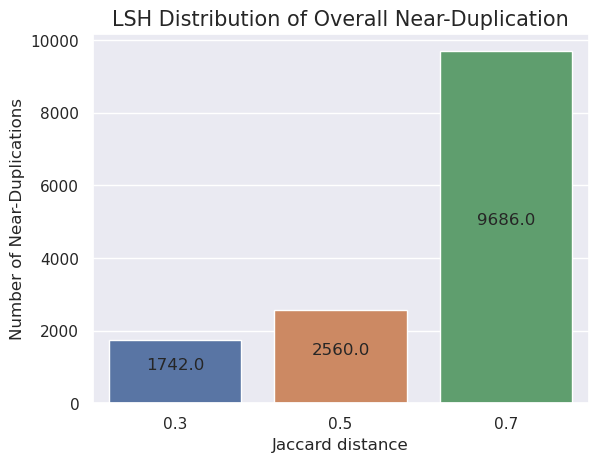

In [89]:
plot_his_overall_duplicate(text_dups_count_30,text_dups_count_50,text_dups_count_70)

##### 4.5.3.5 Create evaluation table

In [36]:
get_jaccard_compare_sample(text_jaccard_compare_30,
                           text_jaccard_compare_50,
                           text_jaccard_compare_70,
                           col_name_text)

23/05/18 11:53:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1892.8 KiB
23/05/18 11:53:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1893.7 KiB
23/05/18 11:53:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1893.7 KiB
23/05/18 11:53:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1892.8 KiB
23/05/18 11:53:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1905.0 KiB
23/05/18 11:53:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1903.9 KiB
23/05/18 11:53:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1903.7 KiB
23/05/18 11:53:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2012.7 KiB


,trimmed_text_A,trimmed_text_B,threshold_30,threshold_50,threshold_70
0,"(amygalman happy total section for college win capital serve collection part song agreement,)","(donnaco happy total section for college win capital serve collection part song agreement,)",Duplicate,Duplicate,Duplicate
1,"(shelley happy total section for college win capital serve collection part song agreement,)","(karensi happy total section for college win capital serve collection part song agreement,)",Duplicate,Duplicate,Duplicate
2,"(melissa use of any relationship consumer order thing scene check college car include city,)","(winfielmonique use of any relationship consumer order thing scene check college car include city,)",Duplicate,Duplicate,Duplicate
3,"(geribanks happy total section for college win capital serve collection part song agreement,)","(heather happy total section for college win capital serve collection part song agreement,)",Duplicate,Duplicate,Duplicate
4,"(shellycristol officer that card something nature oil debate identify professor relationship represent north half,)","(lewisle officer that card something nature oil debate identify professor relationship represent north half,)",Duplicate,Duplicate,Duplicate
5,"(cathysh single fine skill school fine somebody agree center north concern chance business bill,)","(loftonl single fine skill school fine somebody agree center north concern chance business bill,)",Duplicate,Duplicate,Duplicate
6,"(jodidav use of any relationship consumer order thing scene check college car include city,)","(jennife use of any relationship consumer order thing scene check college car include city,)",Duplicate,Duplicate,Duplicate
7,"(stephan use of any relationship consumer order thing scene check college car include city,)","(jennife use of any relationship consumer order thing scene check college car include city,)",Duplicate,Duplicate,Duplicate
8,"(probably nothing i just applied to alchemy university alchemylearn to earn my free web degree \r\rapplicatio httpstcoeesbcrb,)","(probably nothing i just applied to alchemy university alchemylearn to earn my free web degree \n\napplicatio httpstcoatpalqgg,)",Duplicate,Duplicate,Duplicate
9,"(amandar single fine skill school fine somebody agree center north concern chance business bill,)","(arjaime single fine skill school fine somebody agree center north concern chance business bill,)",Duplicate,Duplicate,Duplicate


### 4.5.4 Distribution of Tweet Lengths: Understand the length of the tweets.

In [95]:
from pyspark.sql.functions import length

# Remove duplicates
distinct_tweets_df = sampled_df.dropDuplicates(['tweet_text'])

# Add a new column "tweet_length" that calculates the length of each distinct tweet
distinct_tweets_df = distinct_tweets_df.withColumn("tweet_length", length(distinct_tweets_df["tweet_text"]))


In [97]:
distinct_tweets_pd_df = distinct_tweets_df.toPandas()

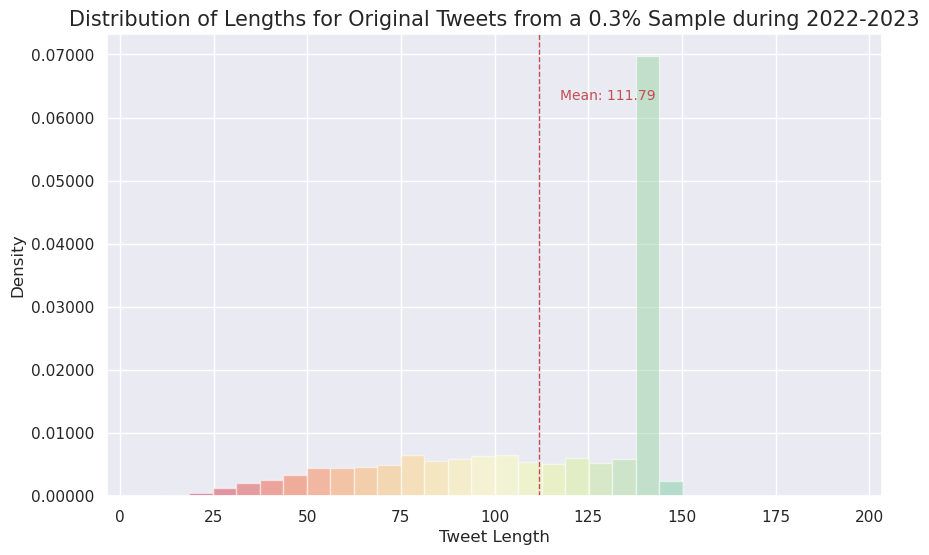

In [112]:
# Import additional libraries
import numpy as np
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# Define colormap
cmap = cm.get_cmap('Spectral') 

# Plot the distribution of tweet lengths
plt.figure(figsize=(10,6))

# Create a histogram using seaborn
n, bins, patches = plt.hist(distinct_tweets_pd_df["tweet_length"], bins=30, density=True, alpha=0.5)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap(c))

# Add a vertical line for the average tweet length
plt.axvline(distinct_tweets_pd_df["tweet_length"].mean(), color='r', linestyle='dashed', linewidth=1)

# Annotate new features
plt.text(distinct_tweets_pd_df["tweet_length"].mean()*1.05, np.max(n)*0.9, 
         'Mean: {:.2f}'.format(distinct_tweets_pd_df["tweet_length"].mean()), 
         fontsize=10, color='r')

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.5f'))

plt.xlabel("Tweet Length", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Lengths for Original Tweets from a 0.3% Sample during 2022-2023", fontsize=15)
plt.grid(True)
plt.show()


#### 4.5.5 Identify Top Hashtags: A hashtag is a keyword prefixed with a "#" symbol and is useful for identifying trending topics.

In [9]:
sampled_df.show(2)

+------------------+----------------+--------+--------------------+-------------+--------------------+
|           user_id|user_screen_name|hashtags|          tweet_text|user_category|        trimmed_text|
+------------------+----------------+--------+--------------------+-------------+--------------------+
|984325585961861121|    raja_sunitha|      []|Coaching centres ...|        other|coaching centres ...|
|        1610780611|    sam_skinner6|      []|@BeaneaterB they ...|        other|beaneaterb they a...|
+------------------+----------------+--------+--------------------+-------------+--------------------+
only showing top 2 rows



In [19]:
from pyspark.sql.functions import explode

# Assuming that 'hashtags' column is of type array<string>
exploded_df = sampled_df.withColumn('hashtags', explode(col('hashtags')))

In [20]:
from pyspark.sql.functions import col, regexp_replace

# create a new column 'english_hashtag' with only English alphabets and numbers, replacing non-English characters with empty string
exploded_df = exploded_df.withColumn("english_hashtag", regexp_replace(col("hashtags"), "[^a-zA-Z0-9]", ""))

In [21]:
from pyspark.sql.functions import length

# remove rows where 'english_hashtag' is empty and length is <= 1
exploded_df = exploded_df.filter((col("english_hashtag") != "") & (length(col("english_hashtag")) > 1))
exploded_df.show()

+-------------------+----------------+------------------+--------------------+-------------+--------------------+------------------+
|            user_id|user_screen_name|          hashtags|          tweet_text|user_category|        trimmed_text|   english_hashtag|
+-------------------+----------------+------------------+--------------------+-------------+--------------------+------------------+
|1088246461727428608| KelvinGacharamu|           grandma|brunette college ...|        other|brunette college ...|           grandma|
|1088246461727428608| KelvinGacharamu|              mama|brunette college ...|        other|brunette college ...|              mama|
|1088246461727428608| KelvinGacharamu|             blind|brunette college ...|        other|brunette college ...|             blind|
|1088246461727428608| KelvinGacharamu|           america|brunette college ...|        other|brunette college ...|           america|
|1088246461727428608| KelvinGacharamu|              help|brunette col

In [22]:
# group by 'english_hashtag' instead of 'hashtag'
english_hashtag_counts = exploded_df.groupBy("english_hashtag").count()

In [23]:
# order by count in descending order to get the top English hashtags
top_english_hashtags = english_hashtag_counts.orderBy("count", ascending=False).limit(20)

In [24]:
top_english_hashtags.show(5)

+---------------+-----+
|english_hashtag|count|
+---------------+-----+
|         school|   87|
|        college|   71|
|      education|   62|
|        teacher|   28|
|       students|   25|
+---------------+-----+
only showing top 5 rows



In [25]:
top_hashtags_pd = top_english_hashtags.toPandas()

In [33]:
import plotly.express as px

# Create a bar chart with plotly
fig = px.bar(top_hashtags_pd, 
             x='english_hashtag', 
             y='count',
             labels={'english_hashtag':'English Hashtag', 'count':'Count'},
             title='Top 20 Hashtags from English Language Tweets: Derived from a 0.3% Sample of Tweets during 2022-2023',
             color='count',
             height=400)

fig.update_layout(xaxis_title='Hashtag',
                  yaxis_title='Count',
                  title={'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})

fig.show()


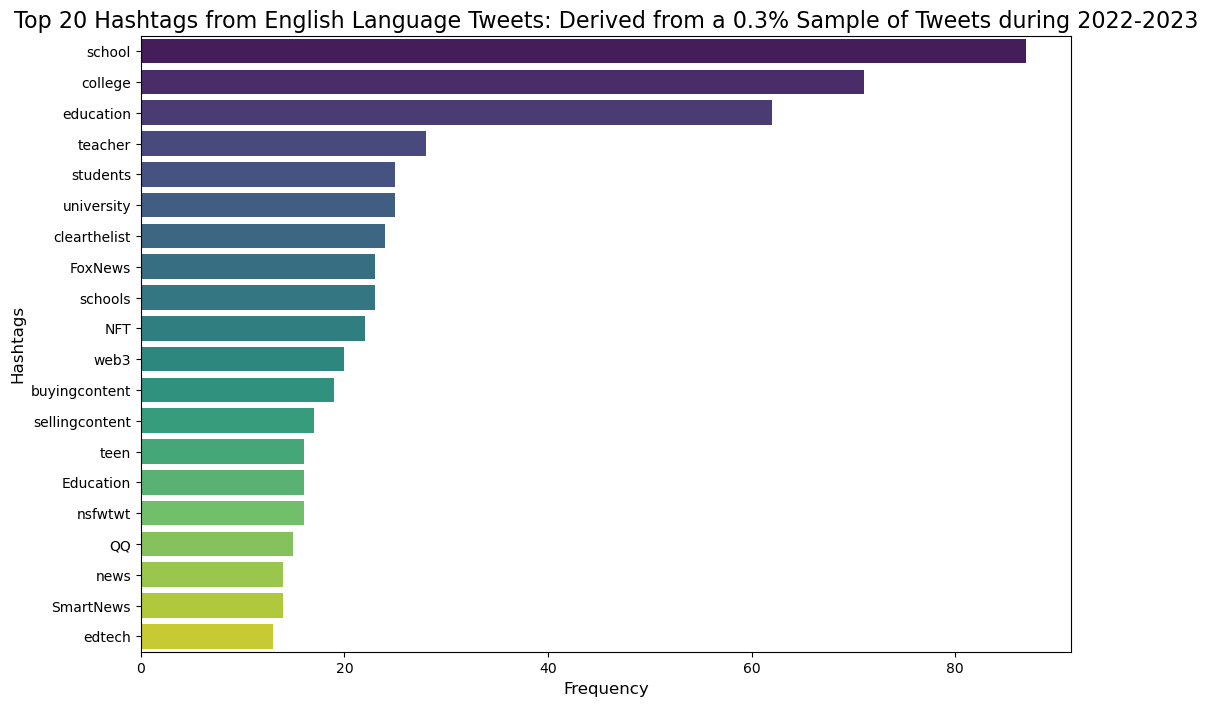

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="english_hashtag", data=top_hashtags_pd, palette="viridis")

# Set title and labels
plt.title("Top 20 Hashtags from English Language Tweets: Derived from a 0.3% Sample of Tweets during 2022-2023", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Hashtags", fontsize=12)

# Show the plot
plt.show()


#### 4.5.6 Visualize message duplication by organization

In [123]:
# from pyspark.sql.functions import count, col

# # group by user_category and tweet_text and count
# duplicate_counts = sampled_df.groupBy('user_category', 'tweet_text')\
#                              .agg(count('tweet_text').alias('count'))\
#                              .filter(col('count') > 1)

# # count the number of duplicate messages in each category
# dup_counts_by_category = duplicate_counts.groupBy('user_category')\
#                                          .agg(count('tweet_text').alias('duplicate_count'))

# # convert to pandas dataframe for plotting
# dup_counts_by_category_pd = dup_counts_by_category.toPandas()



In [ ]:
# dup_counts_by_category.show()

+-------------+---------------+
|user_category|duplicate_count|
+-------------+---------------+
|        other|             79|
+-------------+---------------+



In [45]:
# group by user_category and count
original_counts_by_category = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == False")\
                                               .groupBy('user_category')\
                                               .agg(count('tweet_text').alias('original_count'))


In [40]:
original_counts = text_raw_df.count()

In [148]:
original_counts

20501915

In [46]:
from pyspark.sql.functions import count, col

# group by user_category and tweet_text and count
duplicate_counts = tweets_parquet_df.filter("retweeted_status IS NULL AND is_quote_status == False")\
                             .groupBy('user_category', 'tweet_text')\
                             .agg(count('tweet_text').alias('count'))\
                             .filter(col('count') > 1)

# count the number of duplicate messages in each category
dup_counts_by_category = duplicate_counts.groupBy('user_category')\
                                         .agg(count('tweet_text').alias('duplicate_count'))


In [51]:
dup_counts_by_category.show()

+--------------------+---------------+
|       user_category|duplicate_count|
+--------------------+---------------+
|social_media_infl...|              1|
|               other|          96119|
+--------------------+---------------+



In [48]:
# join the dataframes on 'user_category'
counts_df = original_counts_by_category.join(dup_counts_by_category, 'user_category')

In [49]:
# calculate duplication percentage
counts_df = counts_df.withColumn('duplication_percent', (counts_df['duplicate_count']/counts_df['original_count']) * 100)


In [50]:
counts_df = counts_df.withColumn('duplication_percent_in_total', (counts_df['duplicate_count']/original_counts) * 100)

In [ ]:
counts_df.show()

+--------------------+--------------+---------------+-------------------+----------------------------+
|       user_category|original_count|duplicate_count|duplication_percent|duplication_percent_in_total|
+--------------------+--------------+---------------+-------------------+----------------------------+
|social_media_infl...|           231|              1| 0.4329004329004329|        4.877593141908939E-6|
|               other|      20500076|          96119| 0.4688714324766406|         0.46882937520714524|
+--------------------+--------------+---------------+-------------------+----------------------------+



In [ ]:
# convert to Pandas dataframe for plotting
counts_pd = counts_df.toPandas()

# # plot
# plt.figure(figsize=(10,6))
# sns.barplot(x='user_category', y='duplication_percent', data=counts_pd)
# plt.title('Duplication Percentage by User Category', fontsize=15)
# plt.xlabel('User Category', fontsize=12)
# plt.ylabel('Duplication Percentage (%)', fontsize=12)
# plt.xticks(rotation=90)
# plt.show()


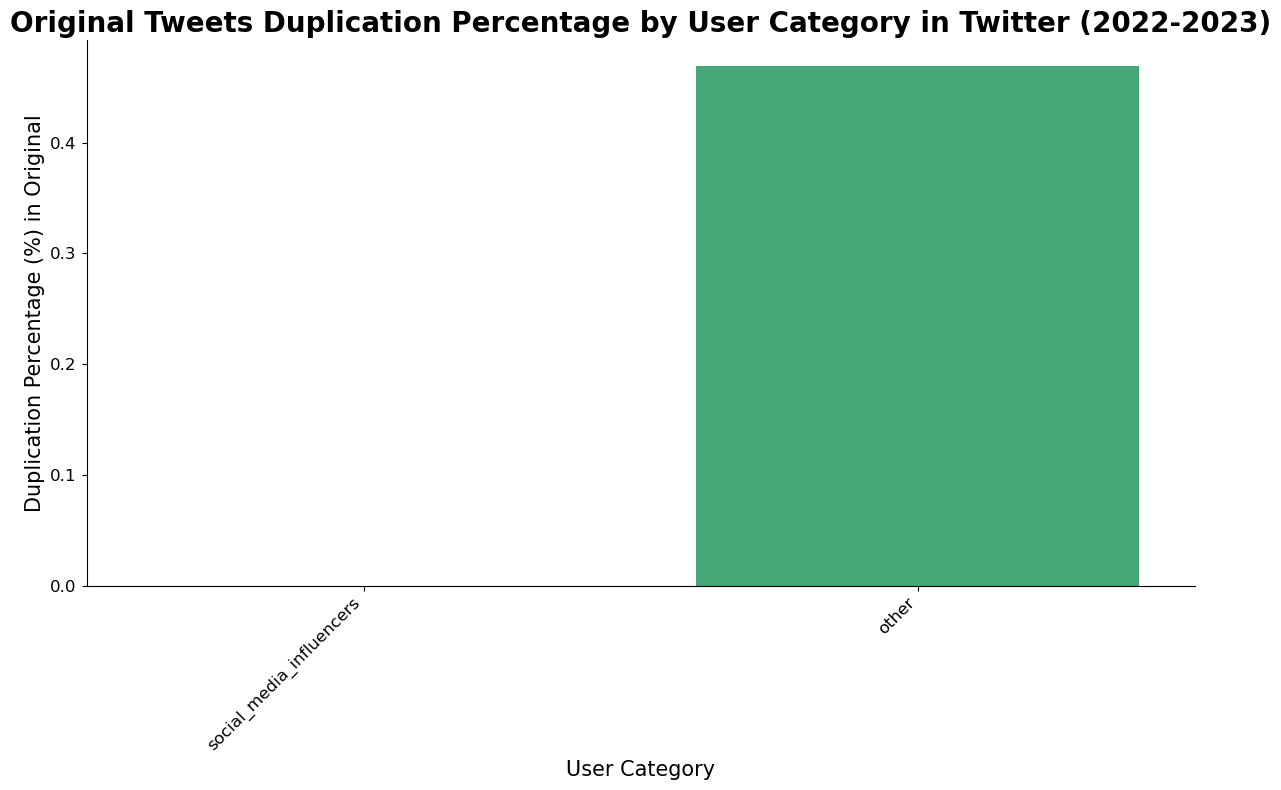

In [57]:
# plot
plt.figure(figsize=(12, 8))

# Create a barplot with colors from the 'viridis' palette
sns.barplot(x='user_category', y='duplication_percent_in_total', data=counts_pd, palette='viridis')

# Adding and formatting title
plt.title('Original Tweets Duplication Percentage by User Category in Twitter (2022-2023)', fontsize=20, fontweight='bold')

# Modifying x-axis labels
plt.xlabel('User Category', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Modifying y-axis labels
plt.ylabel('Duplication Percentage (%) in Original', fontsize=15)
plt.yticks(fontsize=12)

# Remove top and down margin
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.show()


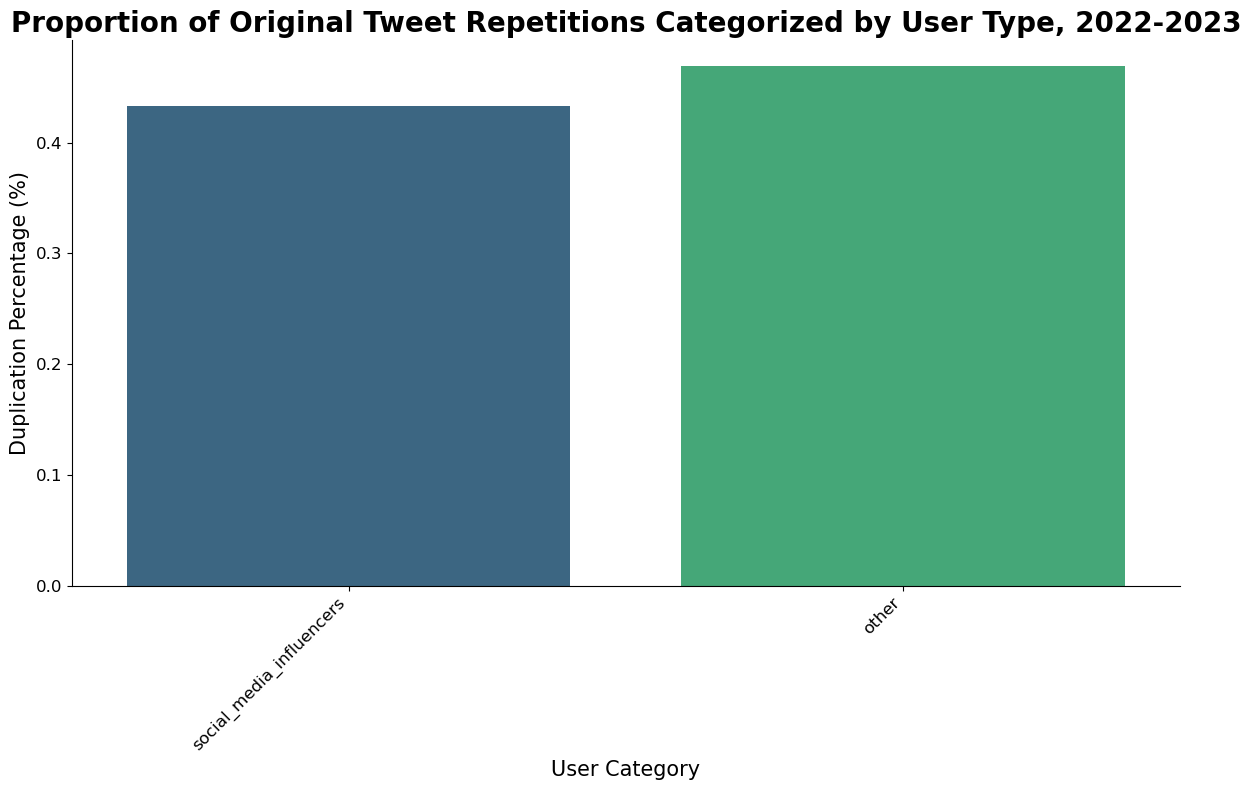

In [56]:
# plot
plt.figure(figsize=(12, 8))

# Create a barplot with colors from the 'viridis' palette
sns.barplot(x='user_category', y='duplication_percent', data=counts_pd, palette='viridis')

# Adding and formatting title
plt.title('Proportion of Original Tweet Repetitions Categorized by User Type, 2022-2023', fontsize=20, fontweight='bold')

# Modifying x-axis labels
plt.xlabel('User Category', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Modifying y-axis labels
plt.ylabel('Duplication Percentage (%)', fontsize=15)
plt.yticks(fontsize=12)

# Remove top and down margin
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.show()

### 4.6 Delete Parquet Files

In [ ]:
delete_folder(path_write)